# Processing Data, Gaining Some Insights and Preparing Tokenizations

## Table Of Contents (ToC) - to do later


1. [Processing Data And Gaining Some Insights](#processing-data-and-gaining-some-insights)
   - *Introduction and objectives of the notebook.*
2. [Table Of Contents (ToC)](#table-of-contents-toc)
   - *This section links to all major parts of the notebook.*
3. [Early Processing](#early-processing)
   - *Removing NA values and filtering rows with incorrect dates.*
4. [Further Processing](#further-processing)
   - *XDXX*
5. [WHAT TEST](#WHAT)

## `99)` Utility Functions

### 1) READING PARQUET DATA IN BATCHES TO AVOID CLOGGING COMPUTER

In [2]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm.auto import tqdm

def read_parquet_in_batches_with_progress(file_path, batch_size):
    """
    Read a Parquet file in fixed-size row batches with a progress bar and per-chunk logging.

    Args:
        file_path (str): Path to the Parquet file.
        batch_size (int): Number of rows per batch.

    Returns:
        pd.DataFrame: Combined DataFrame after processing all batches.
    """
    # Open the Parquet file
    parquet_file = pq.ParquetFile(file_path)
    
    # Total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Initialize a list to store DataFrame chunks
    all_chunks = []
    
    # Initialize the progress bar
    with tqdm(total=total_rows, desc="Processing Batches", unit="rows") as pbar:
        # Enumerate batches for logging
        for batch_number, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size), start=1):
            # Convert the batch to a Pandas DataFrame
            df_batch = batch.to_pandas()
            
            # Simulate processing (add your custom logic here)
            all_chunks.append(df_batch)
            
            # Update the progress bar
            pbar.update(len(df_batch))
            
            # Print per-chunk information
            print(f"Processed Chunk {batch_number}: {len(df_batch)} rows")
    
    # Combine all chunks into a single DataFrame
    combined_df = pd.concat(all_chunks, ignore_index=True)
    
    return combined_df

````
# EXAMPLE USAGE
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P1_all.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df)} rows:")
    df.head()
    ````


### 2) SAVING DF IN BATCHES INTO PARQUET TO AVOID CLOGGING

In [3]:
import os
import pandas as pd
from tqdm import tqdm

def save_and_merge_in_batches(
    df: pd.DataFrame,
    batch_size: int,
    output_folder: str,
    final_filename: str = "final_merged.parquet",
    temp_batch_prefix: str = "temp_batch_"
):
    """
    Splits 'df' into multiple batches (size = batch_size), writes each batch to a Parquet file,
    then merges them into one final Parquet, with a progress bar showing how many batches are done.

    Steps:
    ------
    1) Creates subfolder 'temp_batches' in output_folder for batch files.
    2) For each chunk of rows:
       - Writes it to 'temp_batch_X.parquet'
       - Increments a progress bar
    3) Reads & merges all batch files into 'final_filename', then removes them.

    Returns:
    --------
    str -> path to the final merged Parquet file.
    """

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Subfolder for temporary batch files
    temp_folder = os.path.join(output_folder, "temp_batches")
    os.makedirs(temp_folder, exist_ok=True)

    total_rows = len(df)
    batch_count = (total_rows + batch_size - 1) // batch_size
    print(f"Splitting DataFrame of {total_rows} rows into {batch_count} batches (size={batch_size}).")

    temp_files = []
    current_row = 0
    batch_index = 1

    # -- 1) SAVE IN MULTIPLE BATCHES WITH A PROGRESS BAR FOR THE BATCHES --
    with tqdm(total=batch_count, desc="Saving Batches", unit="batch") as pbar:
        while current_row < total_rows:
            end_row = min(current_row + batch_size, total_rows)
            df_batch = df.iloc[current_row:end_row]

            temp_file_name = f"{temp_batch_prefix}{batch_index}.parquet"
            temp_file_path = os.path.join(temp_folder, temp_file_name)

            # Write the chunk (one shot for each batch)
            df_batch.to_parquet(temp_file_path, index=False, compression="snappy")

            temp_files.append(temp_file_path)

            # Update progress bar
            pbar.update(1)

            # Optional: Print log
            print(f"  -> Batch {batch_index} rows [{current_row}:{end_row}] saved to {temp_file_path}")

            current_row = end_row
            batch_index += 1

    # -- 2) MERGE ALL BATCH FILES INTO A SINGLE PARQUET --
    final_file_path = os.path.join(output_folder, final_filename)
    print(f"\nMerging {len(temp_files)} batch files into {final_file_path}...")

    merged_parts = []
    # Another progress bar for reading merges (optional)
    with tqdm(total=len(temp_files), desc="Merging Batches", unit="file") as pbar_merge:
        for file_path in temp_files:
            merged_parts.append(pd.read_parquet(file_path))
            pbar_merge.update(1)

    df_merged = pd.concat(merged_parts, ignore_index=True)
    df_merged.to_parquet(final_file_path, index=False, compression="snappy")
    print(f"Final merged DataFrame saved as: {final_file_path}\n")

    # -- 3) CLEAN UP TEMPORARY FILES --
    for path in temp_files:
        os.remove(path)
    os.rmdir(temp_folder)

    print("Temporary batch files removed. All done!")
    return final_file_path

````
# ---------------------------
# EXAMPLE USAGE
# ---------------------------
if __name__ == "__main__":

    folder_path = "Data/2.Processed/ModellingData"
    final_file = "P4_final_merged.parquet"
    batch_size = 100_000  # e.g. if you want ~10 batches

    result_path = save_and_merge_in_batches(
        df=df_final,
        batch_size=batch_size,
        output_folder=folder_path,
        final_filename=final_file,
        temp_batch_prefix="temp_batch_"
    )

    print(f"All done. Merged file at: {result_path}")
````

## Early Processing 

*removing NA + filtering rows with wrong dates*

### Step 0: Setup

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_parquet("Data/1.EarlyCleaned/cleaned_parquet/final/PubMedAbstracts_final.parquet")
df.head()

uid                                              title  \
0  10150804  Evaluation of survival in medically treated pa...   
1   9061841  Cohort versus cross-sectional design in large ...   
2   9061840  Network analytic methods for epidemiological r...   
3   9061838  Estimating age, period and cohort effects usin...   
4  16353609  A perspective on the hormonal abnormalities of...   

                                          journal      pubdate  \
0  Journal of insurance medicine (New York, N.Y.)   None-01-01   
1                          Statistics in medicine  1994-Jan-15   
2                          Statistics in medicine  1994-Jan-15   
3                          Statistics in medicine  1994-Jan-15   
4                                Obesity research  1994-Jan-01   

                                            abstract  \
0  General: Articles published in medical journal...   
1  General: In planning large longitudinal field ...   
2  General: The authors measure the efficacy of t...   
3  General: To understand cancer aetiology better...   
4  General: Studies in our laboratory and elsewhe...   

                                             authors  \
0                                       Iacovino J R   
1                          Feldman H A; McKinlay S M   
2  Altmann M; Wee B C; Willard K; Peterson D; Gat...   
3                    Holford T R; Zhang Z; McKay L A   
4                               Zumoff B; Strain G W   

                                        affiliations  \
0    New York Life Insurance Company, New York, USA.   
1  New England Research Institute, Inc., Watertow...   
2  Division of Health Computer Sciences, Universi...   
3  Department of Epidemiology and Public Health, ...   
4  Division of Endocrinology and Metabolism, Depa...   

                                          mesh_terms keywords coi_statement  \
0  Adolescent; Adult; Age Distribution; Chelation...                    N/A   
1  Analysis of Variance; Cluster Analysis; Cohort...                    N/A   
2  Analysis of Variance; Communicable Disease Con...                    N/A   
3  Age Factors; Cell Transformation, Neoplastic; ...                    N/A   
4  Adolescent; Adult; Estradiol; Estrone; Female;...                    N/A   

         date parsed_date  
0  1994-01-01  1994-01-01  
1  1994-01-01  1994-01-15  
2  1994-01-01  1994-01-15  
3  1994-01-01  1994-01-15  
4  1994-01-01  1994-01-01

In [6]:
# na per column 
df.isna().sum()

uid               0
title             0
journal           0
pubdate           0
abstract         14
authors           0
affiliations      0
mesh_terms        0
keywords          0
coi_statement     0
date              0
parsed_date       0
dtype: int64

### **Step 1**: Filtering rows + removal of missing records (missing abstracts are, after checking manually, missing from articles itself, they are **NOT** due to mistakes in the processing or data gathering)

In [7]:
missing_abstracts = df[df["abstract"].isna()]
print("Rows where 'abstract' is missing:")
missing_abstracts

Rows where 'abstract' is missing:


uid                                              title  \
13973    7479089  Transverse temperature-gradient single-strand ...   
396952  19951381  Probing the limits of regional tissue oxygenat...   
714156  28549132  Selective impairment of goal-directed decision...   
748429  29240851                   Off Target But Hitting the Mark.   
771404  30496332  Towards Scalable Hospital-Based Palliative Car...   
771443  30475933  The vaginal wellness consultation for treatmen...   
775681  30667412  Nudging Providers to Improve Sleep for Hospita...   
775682  30667405  The Journal of Hospital Medicine in 2019 and B...   
776638  30534643  Clinical Operations Research: A New Frontier f...   
792798  31010740  RETRACTED: Comprehensive Analysis of the Expre...   
801191  31517334  Response to lubiprostone in chronic constipati...   
844289  32919413  Reopening Endoscopy after the COVID-19 Outbrea...   
890623  34212926  Paraquat lung - a rare cause of diffuse parenc...   
903522  34538297  Impact of COVID-19 on Pediatric Immunocompromi...   

                                                  journal      pubdate  \
13973                              Nucleic acids research  1995-Oct-25   
396952                    Critical care (London, England)   2009-01-01   
714156                     Brain : a journal of neurology  2017-Jun-01   
748429                       Journal of hospital medicine  2018-Apr-01   
771404                       Journal of hospital medicine  2018-Dec-01   
771443         Seminars in cutaneous medicine and surgery  2018-Dec-01   
775681                       Journal of hospital medicine  2019-Jan-01   
775682                       Journal of hospital medicine  2019-Jan-01   
776638                       Journal of hospital medicine  2019-Jan-08   
792798  Molecular therapy : the journal of the America...  2019-Jun-05   
801191  Journal of gastrointestinal and liver diseases...  2019-Sep-01   
844289  Journal of gastrointestinal and liver diseases...  2020-Sep-09   
890623                 Acta bio-medica : Atenei Parmensis  2021-Jul-01   
903522                 Pediatric clinics of North America  2021-Oct-01   

       abstract                                            authors  \
13973      None  Grace M B; Bambeck G S; Buzard G S; Weintraub B D   
396952     None                     Pinsky Michael R; Payen Didier   
714156     None  Reber Justin; Feinstein Justin S; O'Doherty Jo...   
748429     None  Kara Areeba; Mookherjee Somnath; Gavin Warren;...   
771404     None            Courtright Katherine R; O'Connor Nina R   
771443     None                                     Miller Misha D   
775681     None               Auriemma Catherine L; Greysen S Ryan   
775682     None                                       Shah Samir S   
776638     None                        Kohn Rachel; Greysen S Ryan   
792798     None  Sun Cheng-Cao; Li Shu-Jun; Hu Wei; Zhang Jian;...   
801191     None  Tarasiuk Aleksandra; Milad Mena; Ahmed Syed T;...   
844289     None  Elli Luca; Tontini Gian Eugenio; Scaramella Lu...   
890623     None  Agarwal Mehul; Gupta Manohar Lal; Deokar Kunal...   
903522     None  Connelly James A; Chong Hey; Esbenshade Adam J...   

                                             affiliations  \
13973   Diabetes and Digestive and Kidney Diseases, Na...   
396952  Critical Care Medicine, Bioengineering, Cardio...   
714156  Department of Psychological and Brain Sciences...   
748429  Inpatient Medicine, Indiana University Health ...   
771404  Division of Pulmonary, Allergy, and Critical C...   
771443  Mohs Micrographic Surgery and Cutaneous Oncolo...   
775681  Division of Pulmonary and Critical Care Medici...   
775682  Divisions of Hospital Medicine and Infectious ...   
776638  Department of Medicine, Perelman School of Med...   
792798  Department of Occupational and Environmental H...   
801191  Department of Biochemistry, Medical University...   
844289  Gastroenterology and Endoscopy Unit, Fondazio

In [8]:
x = (df.shape)

# 1) Drop rows with missing abstract (14)
df = df.dropna(subset=["abstract"])

print("Removed missing abstract rows:")
print(x[0]-df.shape[0])

# 2) Drop rows with year == 2025
# first ensure parsed_date is datetime
df["parsed_date"] = pd.to_datetime(df["parsed_date"], errors="coerce")

#df = df[df["parsed_date"].dt.year != 2025]
# Exclude years 1994 and 2025 ; 1994 has low amount of articles
df = df[(df["parsed_date"].dt.year != 1994) & (df["parsed_date"].dt.year != 2025)]

print("Removed total rows:")
print(x[0] - df.shape[0])

Removed missing abstract rows:
14
Removed total rows:
1890


In [9]:
# Selecting only columns that we will be working with
df = df[["uid", "title", "journal", "abstract", "authors", "affiliations", "mesh_terms", "keywords", "coi_statement", "parsed_date"]].copy()

## Further Processing

In [10]:
df.columns

Index(['uid', 'title', 'journal', 'abstract', 'authors', 'affiliations',
       'mesh_terms', 'keywords', 'coi_statement', 'parsed_date'],
      dtype='object')

### Variable: `uid` + `parsed_date`

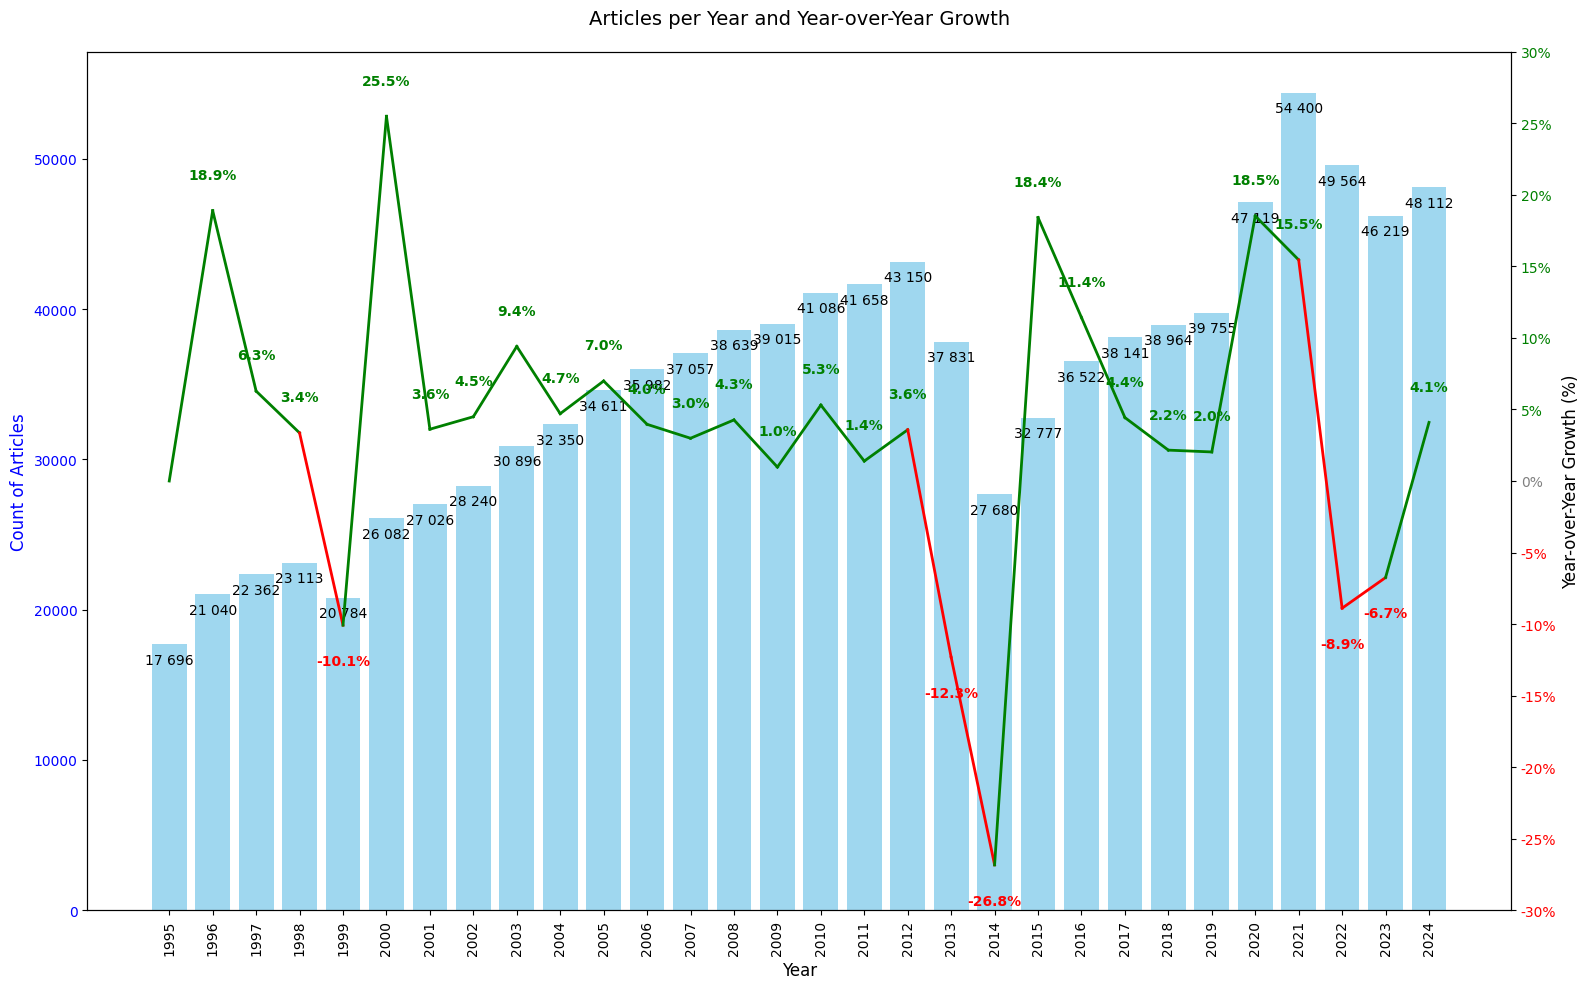

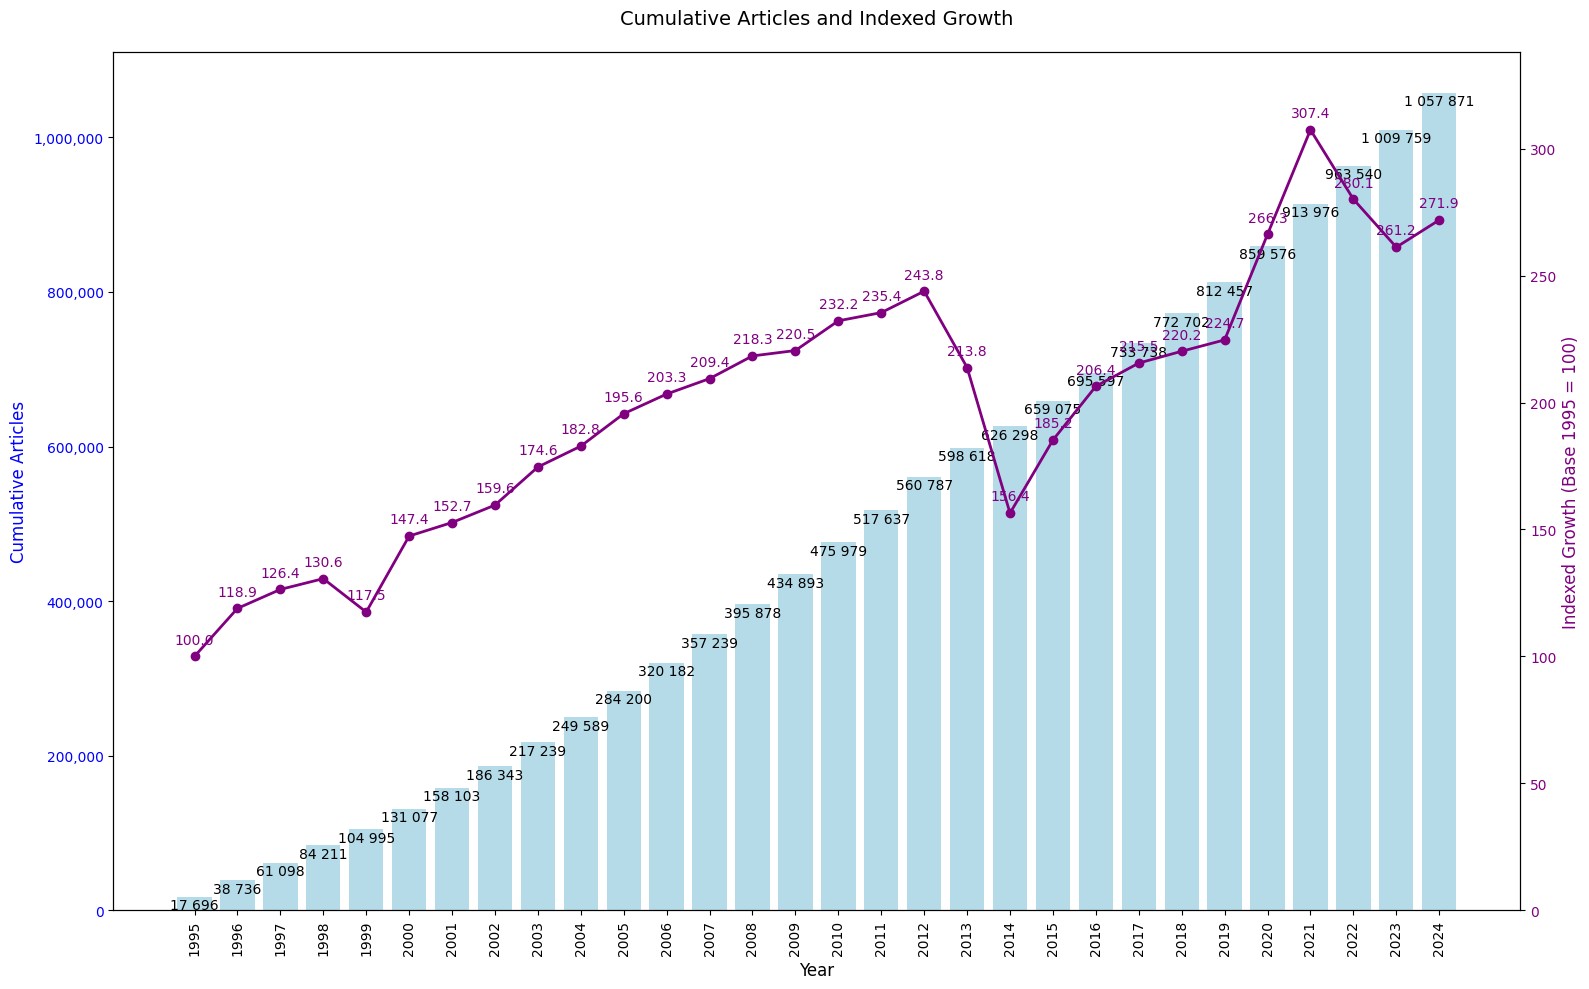

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame and "parsed_date" is the column with dates
df["parsed_date"] = pd.to_datetime(df["parsed_date"], errors="coerce")

# Compute articles per year
articles_per_year = df.groupby(df["parsed_date"].dt.year)["uid"].count().sort_index()

# Compute Year-over-Year % change
growth_pct = articles_per_year.pct_change().fillna(0) * 100
growth_pct.iloc[0] = 0  # Set the first year's growth to 0 to avoid outliers

# Ensure all years from 1995 to 2024 are represented (even if no data for some years)
all_years = pd.Series(range(1995, 2025), name="Year")
articles_per_year = articles_per_year.reindex(all_years, fill_value=0)
growth_pct = growth_pct.reindex(all_years, fill_value=0)

# Compute cumulative number of articles
cumulative_articles = articles_per_year.cumsum()

# Compute Indexed Growth (base 1995 = 100)
indexed_growth = (articles_per_year / articles_per_year.iloc[0]) * 100

# --- Visualization 1: Articles per Year + YoY Growth ---
fig, ax1 = plt.subplots(figsize=(16, 10))

# Adjust the bar width and opacity
bar_width = 0.8
bars = ax1.bar(articles_per_year.index, articles_per_year.values, color="skyblue", alpha=0.8, width=bar_width, label="Article Count")
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Count of Articles", color="blue", fontsize=12)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticks(articles_per_year.index)
ax1.set_xticklabels(articles_per_year.index, rotation=90, fontsize=10)

# Annotate each bar with its count (formatted with commas or spaces), slightly raised
for rect in bars:
    height = rect.get_height()
    if height > 0:  # Annotate only if count > 0
        ax1.text(
            rect.get_x() + rect.get_width() / 2, height - 1500,  # Slightly raised above bar tops
            f"{int(height):,}".replace(",", " "), ha="center", va="bottom", fontsize=10
        )

# Secondary axis for growth percentage
ax2 = ax1.twinx()
ax2.set_ylabel("Year-over-Year Growth (%)", fontsize=12)
ax2.tick_params(axis='y')

# Custom Y-axis ticks with range -30 to 30
ax2.set_ylim(-30, 30)
ax2.set_yticks(range(-30, 35, 5))
ax2.set_yticklabels(
    [f"{abs(t)}%" if t == 0 else f"{t}%" for t in range(-30, 35, 5)],
    color="gray",
    fontsize=10,
)

# Change color of Y-axis labels dynamically
for label in ax2.get_yticklabels():
    value = int(label.get_text().replace("%", ""))
    if value > 0:
        label.set_color("green")
    elif value < 0:
        label.set_color("red")
    else:
        label.set_color("gray")

# Align the line chart with the center of bars
line_x = articles_per_year.index + (bar_width / 2 - 0.4)
colors = ["green" if y > 0 else "red" for y in growth_pct.values]

# Plot colored growth lines based on percentage
for i in range(1, len(articles_per_year)):
    ax2.plot(
        [line_x[i - 1], line_x[i]],
        [growth_pct.values[i - 1], growth_pct.values[i]],
        color=colors[i],
        linewidth=2
    )

# Annotate growth percentage below/above dots in bold
for x, y in zip(line_x, growth_pct.values):
    if abs(y) > 0.5:  # Annotate only significant changes
        offset = -2 if y < 0 else 2
        ax2.text(
            x, y + offset,
            f"{y:.1f}%", color="green" if y > 0 else "red",
            ha="center", va="bottom" if y > 0 else "top", fontsize=10, fontweight="bold"
        )

# Add a title and adjust layout
ax1.set_title("Articles per Year and Year-over-Year Growth", fontsize=14, pad=20)
fig.tight_layout()
plt.show()

# --- Visualization 2: Indexed Growth + Cumulative Articles ---
fig, ax1 = plt.subplots(figsize=(16, 10))

# Plot cumulative number of articles as bars
bars = ax1.bar(cumulative_articles.index, cumulative_articles.values, color="lightblue", alpha=0.9, width=bar_width, label="Cumulative Articles")
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Cumulative Articles", color="blue", fontsize=12)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticks(cumulative_articles.index)
ax1.set_xticklabels(cumulative_articles.index, rotation=90, fontsize=10)

# Set Y-axis to show absolute values (e.g., 100,000)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Annotate each bar with its cumulative count
for rect in bars:
    height = rect.get_height()
    if height > 0:  # Annotate only if count > 0
        ax1.text(
            rect.get_x() + rect.get_width() / 2, height - 20000,  # Slightly above the bar tops
            f"{int(height):,}".replace(",", " "), ha="center", va="bottom", fontsize=10
        )

# Secondary axis for Indexed Growth
ax2 = ax1.twinx()
ax2.set_ylabel("Indexed Growth (Base 1995 = 100)", color="purple", fontsize=12)
ax2.plot(cumulative_articles.index, indexed_growth.values, color="purple", marker="o", linewidth=2, label="Indexed Growth")

# Annotate points on the purple line (indexed growth)
for x, y in zip(cumulative_articles.index, indexed_growth.values):
    ax2.text(
        x, y + 5,  # Slightly above each point
        f"{y:.1f}", color="purple", fontsize=10, ha="center"
    )

ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylim(0, max(indexed_growth) * 1.1)

# Add a title and adjust layout
ax1.set_title("Cumulative Articles and Indexed Growth", fontsize=14, pad=20)
fig.tight_layout()
plt.show()


### Variable: `title` + `abstract`

In [12]:
from pathlib import Path  # Import Path
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from tqdm import tqdm

# Hugging Face tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def huggingface_tokenize(text, max_len=512):
    """
    Tokenize text with the Hugging Face tokenizer and truncate to max_len.
    """
    if not isinstance(text, str) or not text.strip():
        return []
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=False
    )
    return tokenizer.convert_ids_to_tokens(encoding["input_ids"])

def simple_tokenize(text):
    """
    Simple whitespace and punctuation-based tokenizer.
    """
    import re
    if not isinstance(text, str) or not text.strip():
        return []
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.split()

# Batch processing with progress bar
def process_in_batches(df, column, batch_size=1000, tokenizer_func=None, output_column=None, save_path=None):
    tqdm.pandas()  # Enables progress_apply with tqdm

    # Load existing processed results if the file exists
    if save_path and Path(save_path).exists():
        processed = pd.read_parquet(save_path)
        print(f"Loaded existing results from {save_path}.")
        return processed

    num_batches = (len(df) + batch_size - 1) // batch_size  # Total number of batches
    results = []

    for i in tqdm(range(num_batches), desc="Processing Batches"):
        start = i * batch_size
        end = start + batch_size

        # Process batch and avoid direct assignment to a slice
        batch = df.iloc[start:end]
        tokenized_data = batch[column].progress_apply(tokenizer_func)
        tokenized_df = pd.DataFrame({output_column: tokenized_data}, index=batch.index)
        results.append(tokenized_df)

        # Save progress after each batch
        if save_path:
            pd.concat(results).to_parquet(save_path, index=True)

    return pd.concat(results)

In [13]:
# Process title with both tokenizers
df["title_tokens_simple"] = process_in_batches(
    df, "title", batch_size=100_000, tokenizer_func=simple_tokenize, output_column="title_tokens_simple", save_path="Data/2.Processed/ModellingData/P0.simple_tokens_title.parquet"
)

df["title_tokens_hf"] = process_in_batches(
    df, "title", batch_size=100_000, tokenizer_func=lambda txt: huggingface_tokenize(txt, max_len=512), output_column="title_tokens_hf", save_path="Data/2.Processed/ModellingData/P0.hf_tokens_title.parquet"
)

Loaded existing results from Data/2.Processed/ModellingData/P0.simple_tokens_title.parquet.
Loaded existing results from Data/2.Processed/ModellingData/P0.hf_tokens_title.parquet.


In [14]:
# Process title with both tokenizers
df["abstract_tokens_simple"] = process_in_batches(
    df, "abstract", batch_size=100_000, tokenizer_func=simple_tokenize, output_column="abstract_tokens_simple", save_path="Data/2.Processed/ModellingData/P0.simple_tokens_abstract.parquet"
)

df["abstract_tokens_hf"] = process_in_batches(
    df, "abstract", batch_size=100_000, tokenizer_func=lambda txt: huggingface_tokenize(txt, max_len=512), output_column="abstract_tokens_hf", save_path="Data/2.Processed/ModellingData/P0.hf_tokens_abstract.parquet"
)

Loaded existing results from Data/2.Processed/ModellingData/P0.simple_tokens_abstract.parquet.
Loaded existing results from Data/2.Processed/ModellingData/P0.hf_tokens_abstract.parquet.


In [15]:
df.head()

uid                                              title  \
930  10186596  The potential impact of health care reform on ...   
931  10186588  New Jersey health promotion and disease preven...   
932  10186587  Who will provide preventive services? The chan...   
933  10163501  Cytoreduction of small intestine metastases us...   
934  10157383  Racial differences in access to kidney transpl...   

                                               journal  \
930  Journal of public health management and practi...   
931  Journal of public health management and practi...   
932  Journal of public health management and practi...   
933                     Journal of gynecologic surgery   
934                       Health care financing review   

                                              abstract  \
930  General: This article observes that, despite t...   
931  General: Health promotion is a major component...   
932  General: Health care reform in the United Stat...   
933  General: The Cavitron Ultrasonic Surgical Aspi...   
934  General: Previous work has documented large di...   

                               authors  \
930              Auerbach J; McGuire J   
931                         Louria D B   
932  Pearson T A; Spencer M; Jenkins P   
933                        Adelson M D   
934                         Eggers P W   

                                          affiliations  \
930  HIV/AIDS Bureau, Massachusetts Department of P...   
931  Department of Preventive Medicine and Communit...   
932  Mary Imogene Bassett Research Institute, Coope...   
933  Department of Obstetrics and Gynecology, Crous...   
934  Office of Research and Demonstrations, Health ...   

                                            mesh_terms  \
930  Financing, Government; HIV Infections; Health ...   
931  Female; Health Education; Health Promotion; Hu...   
932  Delivery of Health Care; Female; Health Care R...   
933  Adenocarcinoma; Fallopian Tube Neoplasms; Fema...   
934  Adolescent; Adult; Black or African American; ...   

                                              keywords coi_statement  \
930                                                              N/A   
931                                                              N/A   
932                                                              N/A   
933                                                              N/A   
934  Empirical Approach; End Stage Renal Disease Pr...           N/A   

    parsed_date                                title_tokens_simple  \
930  1995-01-01  [the, potential, impact, of, health, care, ref...   
931  1995-01-01  [new, jersey, health, promotion, and, disease,...   
932  1995-01-01  [who, will, provide, preventive, services, the...   
933  1995-01-01  [cytoreduction, of, small, intestine, metastas...   
934  1995-01-01  [racial, differences, in, access, to, kidney, ...   

                                       title_tokens_hf  \
930  [[CLS], the, potential, impact, of, health, ca...   
931  [[CLS], new, jersey, health, promotion, and, d...   
932  [[CLS], who, will, provide, prevent, ##ive, se...   
933  [[CLS], cy, ##tore, ##duction, of, small, int,...   
934  [[CLS], racial, differences, in, access, to, k...   

                                abstract_tokens_simple  \
930  [general, this, article, observes, that, despi...   
931  [general, health, promotion, is, a, major, com...   
932  [general, health, care, reform, in, the, unite...   
933  [general, the, cavitron, ultrasonic, surgical,...   
934  [general, previous, work, has, documented, lar...   

                                    abstract_tokens_hf  
930  [[CLS], general, :, this, article, observes, t...  
931  [[CLS], general, :, health, promotion, is, a, ...  
932  [[CLS], general, :, health, care, reform, in, ...  
933  [[CLS], general, :, the, ca, ##vi, ##tron, ult...  
934  [[CLS], general, :, previous, work, has, docum...

#### 0) Insight into `simple` and `hugging face` tokenization

In [16]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["title_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["title_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(20)
hf_token_freq = Counter(hf_token_flat).most_common(20)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

   Simple Tokens  Simple Frequency HF Tokens  HF Frequency
0             of            752824     [CLS]       1057871
1            and            580862     [SEP]       1057871
2             in            564871         .       1054533
3            the            394711        of        752918
4              a            297509         -        621026
5           with            227261       and        582873
6            for            203622        in        581329
7        disease            138489       the        400449
8             to            133638         :        335712
9       patients             99181         a        290922
10            on             73151      with        227337
11        cancer             71336         ,        208135
12         study             68646       for        203958
13          from             56280   disease        138753
14     treatment             54923        to        136885
15            an             54461       ##s        1340

In [17]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["abstract_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["abstract_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(20)
hf_token_freq = Counter(hf_token_flat).most_common(20)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

   Simple Tokens  Simple Frequency HF Tokens  HF Frequency
0            the           9007908         .      12749311
1             of           8798344         ,      10883008
2            and           8345723       the       8894333
3             in           5595886        of       8613396
4             to           4427437       and       8185741
5              a           3543218         -       6632571
6           with           3297571        in       5635904
7            for           2471641         )       4660852
8       patients           1706513         (       4639568
9           were           1699731        to       4354021
10           was           1561049         a       3393098
11            is           1560850      with       3211453
12          that           1419716         :       2723088
13            or           1157258       for       2410120
14            as           1071864       ##s       1885318
15       disease           1034488         %       17542

In [18]:
from nltk.corpus import stopwords
import nltk

# Download stopwords from NLTK
nltk.download("stopwords")

# Get the list of stopwords
stop_words = set(stopwords.words("english"))

# Remove stopwords from the tokens titles
df["cleaned_title_tokens_simple"] = df["title_tokens_simple"].apply(lambda tokens: [t for t in tokens if t not in stop_words])
df["cleaned_title_tokens_hf"] = df["title_tokens_hf"].apply(lambda tokens: [t for t in tokens if t not in stop_words])

# Remove stopwords from the tokens abstracts
df["cleaned_abstract_tokens_simple"] = df["abstract_tokens_simple"].apply(lambda tokens: [t for t in tokens if t not in stop_words])
df["cleaned_abstract_tokens_hf"] = df["abstract_tokens_hf"].apply(lambda tokens: [t for t in tokens if t not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
punctuation_tokens = {".", ",", "-", ":", ";", "(", ")", "[", "]", "{", "}", "`", "'"}
def remove_punctuation(tokens):
    return [t for t in tokens if t not in punctuation_tokens]

# Then:
df["cleaned_title_tokens_simple"] = df["cleaned_title_tokens_simple"].apply(remove_punctuation).copy()
df["cleaned_title_tokens_hf"] = df["cleaned_title_tokens_hf"].apply(remove_punctuation).copy()

# Then:
df["cleaned_abstract_tokens_simple"] = df["cleaned_abstract_tokens_simple"].apply(remove_punctuation).copy()
df["cleaned_abstract_tokens_hf"] = df["cleaned_abstract_tokens_hf"].apply(remove_punctuation).copy()

In [20]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["cleaned_title_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["cleaned_title_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(50)
hf_token_freq = Counter(hf_token_flat).most_common(50)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

     Simple Tokens  Simple Frequency   HF Tokens  HF Frequency
0          disease            138489       [CLS]       1057871
1         patients             99181       [SEP]       1057871
2           cancer             71336     disease        138753
3            study             68646         ##s        134053
4        treatment             54923    patients         99187
5             risk             52288      cancer         71420
6             cell             52264       study         68649
7           health             46194        ##al         66945
8            human             45974         ##l         55461
9         clinical             45395   treatment         54924
10      associated             43387        cell         52561
11        analysis             42291        risk         52293
12           among             38183          co         51123
13          review             36963    clinical         47425
14         therapy             36721       human       

In [21]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["cleaned_abstract_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["cleaned_abstract_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(50)
hf_token_freq = Counter(hf_token_flat).most_common(50)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

    Simple Tokens  Simple Frequency   HF Tokens  HF Frequency
0        patients           1706513         ##s       1885318
1         disease           1034488           %       1754254
2         general            718994    patients       1658921
3               p            712975           0       1093863
4           study            612552           1       1080633
5         results            604930       [CLS]       1057868
6            risk            579705       [SEP]       1057868
7      associated            569919     disease       1021327
8       treatment            555803           /        949107
9        clinical            487254           p        810667
10            may            460930           =        805119
11         health            404141           2        782942
12           data            400931     general        722766
13        methods            387033         ##d        691523
14         cancer            373179       study        599368
15      

##### Conclusions from 0)

Based on our initial exploration, both simple tokenization and Hugging Face-based tokenization appear to be viable approaches for our research. 

However, cleaning required for these methods may prove to be overly time-intensive. 

As a result, we will prioritize alternative approaches for the time being. If these alternative methods fail to give satisfactory results, we will revisit and upgrade the tokenization-based strategy.

In [22]:
df.head()

uid                                              title  \
930  10186596  The potential impact of health care reform on ...   
931  10186588  New Jersey health promotion and disease preven...   
932  10186587  Who will provide preventive services? The chan...   
933  10163501  Cytoreduction of small intestine metastases us...   
934  10157383  Racial differences in access to kidney transpl...   

                                               journal  \
930  Journal of public health management and practi...   
931  Journal of public health management and practi...   
932  Journal of public health management and practi...   
933                     Journal of gynecologic surgery   
934                       Health care financing review   

                                              abstract  \
930  General: This article observes that, despite t...   
931  General: Health promotion is a major component...   
932  General: Health care reform in the United Stat...   
933  General: The Cavitron Ultrasonic Surgical Aspi...   
934  General: Previous work has documented large di...   

                               authors  \
930              Auerbach J; McGuire J   
931                         Louria D B   
932  Pearson T A; Spencer M; Jenkins P   
933                        Adelson M D   
934                         Eggers P W   

                                          affiliations  \
930  HIV/AIDS Bureau, Massachusetts Department of P...   
931  Department of Preventive Medicine and Communit...   
932  Mary Imogene Bassett Research Institute, Coope...   
933  Department of Obstetrics and Gynecology, Crous...   
934  Office of Research and Demonstrations, Health ...   

                                            mesh_terms  \
930  Financing, Government; HIV Infections; Health ...   
931  Female; Health Education; Health Promotion; Hu...   
932  Delivery of Health Care; Female; Health Care R...   
933  Adenocarcinoma; Fallopian Tube Neoplasms; Fema...   
934  Adolescent; Adult; Black or African American; ...   

                                              keywords coi_statement  \
930                                                              N/A   
931                                                              N/A   
932                                                              N/A   
933                                                              N/A   
934  Empirical Approach; End Stage Renal Disease Pr...           N/A   

    parsed_date                                title_tokens_simple  \
930  1995-01-01  [the, potential, impact, of, health, care, ref...   
931  1995-01-01  [new, jersey, health, promotion, and, disease,...   
932  1995-01-01  [who, will, provide, preventive, services, the...   
933  1995-01-01  [cytoreduction, of, small, intestine, metastas...   
934  1995-01-01  [racial, differences, in, access, to, kidney, ...   

                                       title_tokens_hf  \
930  [[CLS], the, potential, impact, of, health, ca...   
931  [[CLS], new, jersey, health, promotion, and, d...   
932  [[CLS], who, will, provide, prevent, ##ive, se...   
933  [[CLS], cy, ##tore, ##duction, of, small, int,...   
934  [[CLS], racial, differences, in, access, to, k...   

                                abstract_tokens_simple  \
930  [general, this, article, observes, that, despi...   
931  [general, health, promotion, is, a, major, com...   
932  [general, health, care, reform, in, the, unite...   
933  [general, the, cavitron, ultrasonic, surgical,...   
934  [general, previous, work, has, documented, lar...   

                                    abstract_tokens_hf  \
930  [[CLS], general, :, this, article, observes, t...   
931  [[CLS], general, :, health, promotion, is, a, ...   
932  [[CLS], general, :, health, care, reform, in, ...   
933  [[CLS], general, :, the, ca, ##vi, ##tron, ult...   
934  [[CLS], general, :, previous, work, has, docum...   

                           cleaned_title_tokens_sim

#### 1) Dictionary-Based Disease Detection

In this approach, We manually create (or load) a disease dictionary (e.g., from ICD codes, known disease names). We then filter tokens to only keep tokens matching that dictionary. This is a straightforward method but can miss synonyms or multi-word diseases unless stored them as multiple entries.

In [23]:
###############################################################################
# 1) Dictionary-Based Approach
###############################################################################

# Example dictionary of diseases (this is just a tiny sample!) - could use some sort of base group of files or something like dict of ilnesses? icd-10-medical-diagnosis-codes maybe?
disease_dict = {
    # General and Common Diseases
    "cancer", "tumor", "diabetes", "hiv", "aids", "arthritis", "pneumonia",
    "hypertension", "influenza", "malaria", "tuberculosis", "dementia", "asthma", 
    "depression", "anxiety", "stroke", "heart disease", "kidney disease",
    
    # Infectious Diseases
    "hepatitis", "cholera", "dengue", "zika", "ebola", "typhoid", "plague",
    "meningitis", "measles", "rubella", "chickenpox", "shingles", "covid",
    "scarlet fever", "leprosy", "syphilis", "gonorrhea", "lyme disease",
    
    # Neurological Disorders
    "parkinson's disease", "epilepsy", "multiple sclerosis", "migraine", 
    "alzheimer's disease", "amyotrophic lateral sclerosis", "huntington's disease",
    "cerebral palsy", "autism", "adhd", "schizophrenia", "bipolar disorder",
    
    # Respiratory Diseases
    "bronchitis", "emphysema", "chronic obstructive pulmonary disease (copd)", 
    "sleep apnea", "pulmonary fibrosis", "cystic fibrosis",
    
    # Cardiovascular Diseases
    "high blood pressure", "arrhythmia", "coronary artery disease", 
    "heart failure", "heart attack", "aortic aneurysm", "angina",
    
    # Digestive Disorders
    "irritable bowel syndrome (ibs)", "ulcerative colitis", "crohn's disease",
    "gastritis", "peptic ulcer", "gastroesophageal reflux disease (gerd)",
    "pancreatitis", "hepatitis a", "hepatitis b", "hepatitis c",
    
    # Musculoskeletal Disorders
    "osteoporosis", "rheumatoid arthritis", "osteoarthritis", "gout",
    "fibromyalgia", "scoliosis", "spinal cord injury",
    
    # Endocrine Disorders
    "hyperthyroidism", "hypothyroidism", "cushing's syndrome", "addison's disease",
    "polycystic ovary syndrome (pcos)", "metabolic syndrome",
    
    # Skin Diseases
    "eczema", "psoriasis", "rosacea", "acne", "melanoma", "basal cell carcinoma",
    "squamous cell carcinoma",
    
    # Genetic Disorders
    "down syndrome", "turner syndrome", "klinefelter syndrome", 
    "sickle cell anemia", "cystic fibrosis", "marfan syndrome",
    
    # Blood Disorders
    "anemia", "leukemia", "lymphoma", "hemophilia", "thalassemia",
    "deep vein thrombosis", "pulmonary embolism",
    
    # Eye Diseases
    "cataracts", "glaucoma", "macular degeneration", "diabetic retinopathy",
    "conjunctivitis", "dry eye syndrome",
    
    # Liver Diseases
    "liver cirrhosis", "fatty liver disease", "hepatitis", "liver cancer",
    
    # Kidney and Urinary Diseases
    "kidney stones", "urinary tract infection (uti)", "chronic kidney disease",
    "nephritis", "prostate cancer", "bladder cancer",
    
    # Cancers
    "breast cancer", "lung cancer", "colon cancer", "skin cancer",
    "pancreatic cancer", "prostate cancer", "ovarian cancer", 
    "brain cancer", "thyroid cancer",
    
    # Reproductive Disorders
    "endometriosis", "ovarian cysts", "uterine fibroids", "erectile dysfunction",
    "infertility", "pelvic inflammatory disease (pid)",
    
    # Autoimmune Diseases
    "systemic lupus erythematosus", "hashimoto's disease", "sjogren's syndrome",
    "celiac disease", "graves' disease", "type 1 diabetes",
    
    # Others
    "sepsis", "allergies", "heat stroke", "hypothermia", "obesity",
    "metabolic syndrome", "malnutrition", "alcoholism", "drug addiction",
    "dyslexia", "anorexia", "bulimia", "hyperlipidemia", "bacterial vaginosis"
}



def keep_only_diseases(token_list):
    """
    Return only those tokens present in the disease_dict.
    We do a .lower() to unify. 
    If you have subwords in HF approach (like 'canc', '##er'),
    you might want to check partial matches or reconstruct them.
    """
    return [t for t in token_list if t.lower() in disease_dict]

In [24]:
# Example usage with cleaned columns:
df["disease_title_tokens_simple"] = df["cleaned_title_tokens_simple"].apply(keep_only_diseases)
df["disease_title_tokens_hf"] = df["cleaned_title_tokens_hf"].apply(keep_only_diseases)

# Then, for frequency:
from collections import Counter

disease_flat_simple = [tok for tokens in df["disease_title_tokens_simple"] for tok in tokens]
simple_disease_freq = Counter(disease_flat_simple).most_common(20)

disease_flat_hf = [tok for tokens in df["disease_title_tokens_hf"] for tok in tokens]
hf_disease_freq = Counter(disease_flat_hf).most_common(20)

print("Top 20 diseases title (simple):", simple_disease_freq)
print("Top 20 diseases title (HF):", hf_disease_freq)

Top 20 diseases title (simple): [('cancer', 71336), ('hiv', 29950), ('diabetes', 17710), ('covid', 15644), ('tumor', 12050), ('hepatitis', 8989), ('hypertension', 8285), ('depression', 7959), ('leukemia', 7908), ('obesity', 7316), ('arthritis', 7210), ('stroke', 6950), ('asthma', 6861), ('lymphoma', 6722), ('influenza', 6570), ('dementia', 6565), ('tuberculosis', 5689), ('schizophrenia', 5539), ('melanoma', 4653), ('aids', 3752)]
Top 20 diseases title (HF): [('cancer', 71420), ('hiv', 29984), ('diabetes', 17711), ('tumor', 12985), ('hepatitis', 8989), ('leukemia', 8157), ('depression', 7967), ('obesity', 7316), ('arthritis', 7213), ('asthma', 7209), ('influenza', 7034), ('dementia', 7011), ('stroke', 6957), ('tuberculosis', 5689), ('schizophrenia', 5543), ('pneumonia', 4403), ('aids', 3764), ('malaria', 3433), ('anxiety', 2755), ('autism', 2013)]


In [25]:
# Example usage with your cleaned columns:
df["disease_abstract_tokens_simple"] = df["cleaned_abstract_tokens_simple"].apply(keep_only_diseases)
df["disease_abstract_tokens_hf"] = df["cleaned_abstract_tokens_hf"].apply(keep_only_diseases)

# Then, for frequency:
from collections import Counter

disease_flat_simple = [tok for tokens in df["disease_abstract_tokens_simple"] for tok in tokens]
simple_disease_freq = Counter(disease_flat_simple).most_common(20)

disease_flat_hf = [tok for tokens in df["disease_abstract_tokens_hf"] for tok in tokens]
hf_disease_freq = Counter(disease_flat_hf).most_common(20)

print("Top 20 diseases abstract (simple):", simple_disease_freq)
print("Top 20 diseases abstract (HF):", hf_disease_freq)

Top 20 diseases abstract (simple): [('cancer', 373179), ('hiv', 204593), ('tumor', 149498), ('diabetes', 122518), ('covid', 81759), ('depression', 73186), ('hypertension', 65958), ('stroke', 63889), ('obesity', 58150), ('asthma', 54143), ('dementia', 43989), ('influenza', 37314), ('anxiety', 32909), ('hepatitis', 31614), ('schizophrenia', 27589), ('arthritis', 26089), ('lymphoma', 25888), ('aids', 24439), ('leukemia', 23992), ('melanoma', 23548)]
Top 20 diseases abstract (HF): [('cancer', 367292), ('hiv', 202203), ('tumor', 154808), ('diabetes', 119829), ('depression', 72342), ('stroke', 62292), ('obesity', 57074), ('asthma', 56798), ('dementia', 45508), ('influenza', 38891), ('anxiety', 32447), ('hepatitis', 31211), ('pneumonia', 28793), ('schizophrenia', 27382), ('arthritis', 25695), ('leukemia', 25399), ('aids', 24031), ('malaria', 22374), ('tuberculosis', 22043), ('autism', 8229)]


In [26]:
df.head()

uid                                              title  \
930  10186596  The potential impact of health care reform on ...   
931  10186588  New Jersey health promotion and disease preven...   
932  10186587  Who will provide preventive services? The chan...   
933  10163501  Cytoreduction of small intestine metastases us...   
934  10157383  Racial differences in access to kidney transpl...   

                                               journal  \
930  Journal of public health management and practi...   
931  Journal of public health management and practi...   
932  Journal of public health management and practi...   
933                     Journal of gynecologic surgery   
934                       Health care financing review   

                                              abstract  \
930  General: This article observes that, despite t...   
931  General: Health promotion is a major component...   
932  General: Health care reform in the United Stat...   
933  General: The Cavitron Ultrasonic Surgical Aspi...   
934  General: Previous work has documented large di...   

                               authors  \
930              Auerbach J; McGuire J   
931                         Louria D B   
932  Pearson T A; Spencer M; Jenkins P   
933                        Adelson M D   
934                         Eggers P W   

                                          affiliations  \
930  HIV/AIDS Bureau, Massachusetts Department of P...   
931  Department of Preventive Medicine and Communit...   
932  Mary Imogene Bassett Research Institute, Coope...   
933  Department of Obstetrics and Gynecology, Crous...   
934  Office of Research and Demonstrations, Health ...   

                                            mesh_terms  \
930  Financing, Government; HIV Infections; Health ...   
931  Female; Health Education; Health Promotion; Hu...   
932  Delivery of Health Care; Female; Health Care R...   
933  Adenocarcinoma; Fallopian Tube Neoplasms; Fema...   
934  Adolescent; Adult; Black or African American; ...   

                                              keywords coi_statement  \
930                                                              N/A   
931                                                              N/A   
932                                                              N/A   
933                                                              N/A   
934  Empirical Approach; End Stage Renal Disease Pr...           N/A   

    parsed_date  ...                             abstract_tokens_simple  \
930  1995-01-01  ...  [general, this, article, observes, that, despi...   
931  1995-01-01  ...  [general, health, promotion, is, a, major, com...   
932  1995-01-01  ...  [general, health, care, reform, in, the, unite...   
933  1995-01-01  ...  [general, the, cavitron, ultrasonic, surgical,...   
934  1995-01-01  ...  [general, previous, work, has, documented, lar...   

                                    abstract_tokens_hf  \
930  [[CLS], general, :, this, article, observes, t...   
931  [[CLS], general, :, health, promotion, is, a, ...   
932  [[CLS], general, :, health, care, reform, in, ...   
933  [[CLS], general, :, the, ca, ##vi, ##tron, ult...   
934  [[CLS], general, :, previous, work, has, docum...   

                           cleaned_title_tokens_simple  \
930  [potential, impact, health, care, reform, publ...   
931  [new, jersey, health, promotion, disease, prev...   
932  [provide, preventive, services, changing, rela...   
933  [cytoreduction, small, intestine, metastases, ...   
934  [racial, differences, access, kidney, transpla...   

                               cleaned_title_tokens_hf  \
930  [[CLS], potential, impact, health, care, refor...   
931  [[CLS], new, jersey, health, promotion, diseas...   
932  [[CLS], provide, prevent, ##ive, services, ?, ...   
933  [[CLS], cy, ##tore, ##duction, small, int, ##e...   
934  [[CLS], racial, differences, access, kidney, t...   

                     

**Pros**:

Easy to implement.
You quickly see if “cancer” or “diabetes” is the top disease token.

**Cons**:

Multi-word diseases like “heart failure” or “chronic obstructive pulmonary disease” won’t match unless we store them as separate tokens or reconstruct them.

Subword issues: In Hugging Face tokens, “cancer” might appear as [canc, ##er]. That won’t match “cancer” in disease_dict unless we unify them.

#### 2) `SciSpacy` (or spaCy) Biomedical NER Approach

In this approach, We use a trained biomedical NER model (like en_ner_bc5cdr_md) that can detect DISEASE entities in your text. This can handle multi-word diseases and synonyms automatically. You’ll need to:

Install scispacy: pip install scispacy
Install the specific model, e.g. en_ner_bc5cdr_md, via
pip install "your folder with .zip file" - download at https://allenai.github.io/scispacy/


In [27]:
# install scispacy
#%pip install scispacy

#en_ner_bc5cdr_md	F1 84.28	DISEASE, CHEMICAL

# Check project directory
# import os
# os.getcwd()

In [28]:
# installing certain model from archive file downloaded from scispacy website
#%pip install ScispaCy/en_ner_bc5cdr_md-0.5.4.tar.gz

##### Example Of Usage - scispacy website

In [29]:
# import scispacy
# import spacy

# nlp = spacy.load("en_ner_bc5cdr_md")
# text = """
# Myeloid derived suppressor cells (MDSC) are immature 
# myeloid cells with immunosuppressive activity. 
# They accumulate in tumor-bearing mice and humans 
# with different types of cancer, including hepatocellular 
# carcinoma (HCC).
# """
# doc = nlp(text)

# print(list(doc.sents))
# # >>> ["Myeloid derived suppressor cells (MDSC) are immature myeloid cells with immunosuppressive activity.", 
# #      "They accumulate in tumor-bearing mice and humans with different types of cancer, including hepatocellular carcinoma (HCC)."]

# # Examine the entities extracted by the mention detector.
# # Note that they don't have types like in SpaCy, and they
# # are more general (e.g including verbs) - these are any
# # spans which might be an entity in UMLS, a large
# # biomedical database.
# print(doc.ents)
# # >>> (Myeloid derived suppressor cells,
# #      MDSC,
# #      immature,
# #      myeloid cells,
# #      immunosuppressive activity,
# #      accumulate,
# #      tumor-bearing mice,
# #      humans,
# #      cancer,
# #      hepatocellular carcinoma,
# #      HCC)

# # We can also visualise dependency parses
# # (This renders automatically inside a jupyter notebook!):
# from spacy import displacy
# displacy.render(next(doc.sents), style='dep', jupyter=True)

# # See below for the generated SVG.
# # Zoom your browser in a bit!

##### Cleaning + Setting Up ENV with smaller dataframes

In [30]:
import gc

# Force the garbage collector to run
gc.collect()

0

In [31]:
%who
%whos

AutoTokenizer	 Counter	 Path	 all_years	 articles_per_year	 ax1	 ax2	 bar_width	 bars	 
colors	 cumulative_articles	 df	 disease_dict	 disease_flat_hf	 disease_flat_simple	 fig	 freq_df	 gc	 
growth_pct	 height	 hf_disease_freq	 hf_token_flat	 hf_token_freq	 huggingface_tokenize	 i	 indexed_growth	 keep_only_diseases	 
label	 line_x	 missing_abstracts	 nltk	 np	 offset	 os	 pd	 plt	 
pq	 process_in_batches	 punctuation_tokens	 read_parquet_in_batches_with_progress	 rect	 remove_punctuation	 save_and_merge_in_batches	 simple_disease_freq	 simple_token_flat	 
simple_token_freq	 simple_tokenize	 stop_words	 stopwords	 tokenizer	 tqdm	 value	 x	 y	 

Variable                                Type                       Data/Info
----------------------------------------------------------------------------
AutoTokenizer                           type                       <class 'transformers.mode<...>tion_auto.AutoTokenizer'>
Counter                                 type                       <

In [32]:
df.head()

uid                                              title  \
930  10186596  The potential impact of health care reform on ...   
931  10186588  New Jersey health promotion and disease preven...   
932  10186587  Who will provide preventive services? The chan...   
933  10163501  Cytoreduction of small intestine metastases us...   
934  10157383  Racial differences in access to kidney transpl...   

                                               journal  \
930  Journal of public health management and practi...   
931  Journal of public health management and practi...   
932  Journal of public health management and practi...   
933                     Journal of gynecologic surgery   
934                       Health care financing review   

                                              abstract  \
930  General: This article observes that, despite t...   
931  General: Health promotion is a major component...   
932  General: Health care reform in the United Stat...   
933  General: The Cavitron Ultrasonic Surgical Aspi...   
934  General: Previous work has documented large di...   

                               authors  \
930              Auerbach J; McGuire J   
931                         Louria D B   
932  Pearson T A; Spencer M; Jenkins P   
933                        Adelson M D   
934                         Eggers P W   

                                          affiliations  \
930  HIV/AIDS Bureau, Massachusetts Department of P...   
931  Department of Preventive Medicine and Communit...   
932  Mary Imogene Bassett Research Institute, Coope...   
933  Department of Obstetrics and Gynecology, Crous...   
934  Office of Research and Demonstrations, Health ...   

                                            mesh_terms  \
930  Financing, Government; HIV Infections; Health ...   
931  Female; Health Education; Health Promotion; Hu...   
932  Delivery of Health Care; Female; Health Care R...   
933  Adenocarcinoma; Fallopian Tube Neoplasms; Fema...   
934  Adolescent; Adult; Black or African American; ...   

                                              keywords coi_statement  \
930                                                              N/A   
931                                                              N/A   
932                                                              N/A   
933                                                              N/A   
934  Empirical Approach; End Stage Renal Disease Pr...           N/A   

    parsed_date  ...                             abstract_tokens_simple  \
930  1995-01-01  ...  [general, this, article, observes, that, despi...   
931  1995-01-01  ...  [general, health, promotion, is, a, major, com...   
932  1995-01-01  ...  [general, health, care, reform, in, the, unite...   
933  1995-01-01  ...  [general, the, cavitron, ultrasonic, surgical,...   
934  1995-01-01  ...  [general, previous, work, has, documented, lar...   

                                    abstract_tokens_hf  \
930  [[CLS], general, :, this, article, observes, t...   
931  [[CLS], general, :, health, promotion, is, a, ...   
932  [[CLS], general, :, health, care, reform, in, ...   
933  [[CLS], general, :, the, ca, ##vi, ##tron, ult...   
934  [[CLS], general, :, previous, work, has, docum...   

                           cleaned_title_tokens_simple  \
930  [potential, impact, health, care, reform, publ...   
931  [new, jersey, health, promotion, disease, prev...   
932  [provide, preventive, services, changing, rela...   
933  [cytoreduction, small, intestine, metastases, ...   
934  [racial, differences, access, kidney, transpla...   

                               cleaned_title_tokens_hf  \
930  [[CLS], potential, impact, health, care, refor...   
931  [[CLS], new, jersey, health, promotion, diseas...   
932  [[CLS], provide, prevent, ##ive, services, ?, ...   
933  [[CLS], cy, ##tore, ##duction, small, int, ##e...   
934  [[CLS], racial, differences, access, kidney, t...   

                     

In [33]:
df = df.drop(columns=["abstract_tokens_simple", "abstract_tokens_hf","title_tokens_simple","title_tokens_hf"]).copy()

In [34]:
if __name__ == "__main__":

    folder_path = "Data/2.Processed/ModellingData"
    final_file = "P1_all.parquet"
    batch_size = 100_000 
    
    result_path = save_and_merge_in_batches(
        df=df,
        batch_size=batch_size,
        output_folder=folder_path,
        final_filename=final_file,
        temp_batch_prefix="temp_batch_"
    )

    print(f"All done. Merged file at: {result_path}")

Splitting DataFrame of 1057871 rows into 11 batches (size=100000).


Saving Batches:   9%|▉         | 1/11 [00:08<01:28,  8.83s/batch]

  -> Batch 1 rows [0:100000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_1.parquet


Saving Batches:  18%|█▊        | 2/11 [00:17<01:19,  8.78s/batch]

  -> Batch 2 rows [100000:200000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_2.parquet


Saving Batches:  27%|██▋       | 3/11 [00:26<01:09,  8.74s/batch]

  -> Batch 3 rows [200000:300000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_3.parquet


Saving Batches:  36%|███▋      | 4/11 [00:35<01:01,  8.79s/batch]

  -> Batch 4 rows [300000:400000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_4.parquet


Saving Batches:  45%|████▌     | 5/11 [00:44<00:53,  8.88s/batch]

  -> Batch 5 rows [400000:500000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_5.parquet


Saving Batches:  55%|█████▍    | 6/11 [00:54<00:47,  9.43s/batch]

  -> Batch 6 rows [500000:600000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_6.parquet


Saving Batches:  64%|██████▎   | 7/11 [01:06<00:40, 10.11s/batch]

  -> Batch 7 rows [600000:700000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_7.parquet


Saving Batches:  73%|███████▎  | 8/11 [01:17<00:31, 10.62s/batch]

  -> Batch 8 rows [700000:800000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_8.parquet


Saving Batches:  82%|████████▏ | 9/11 [01:29<00:21, 10.89s/batch]

  -> Batch 9 rows [800000:900000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_9.parquet


Saving Batches:  91%|█████████ | 10/11 [01:41<00:11, 11.25s/batch]

  -> Batch 10 rows [900000:1000000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_10.parquet


Saving Batches: 100%|██████████| 11/11 [01:48<00:00,  9.84s/batch]


  -> Batch 11 rows [1000000:1057871] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_11.parquet

Merging 11 batch files into Data/2.Processed/ModellingData\P1_all.parquet...


Merging Batches: 100%|██████████| 11/11 [01:01<00:00,  5.64s/file]


Final merged DataFrame saved as: Data/2.Processed/ModellingData\P1_all.parquet

Temporary batch files removed. All done!
All done. Merged file at: Data/2.Processed/ModellingData\P1_all.parquet


`UID` Distinct:
1057871 (100%)


In [35]:
df_title = df[['uid', 'title']].copy()
df_abstract = df[['uid', 'abstract']].copy()

In [36]:
import os 

# Folder and file paths
folder_path = "Data/2.Processed/ModellingData"

file_name_title = "P2_title.parquet"
file_name_abstract = "P2_abstract.parquet"

file_path_title = os.path.join(folder_path, file_name_title)
file_path_abstract = os.path.join(folder_path, file_name_abstract)

# 1. Save the DataFrame as a single Parquet file
df_title.to_parquet(file_path_title, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_title}")

df_abstract.to_parquet(file_path_abstract, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_abstract}")

DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P2_title.parquet
DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P2_abstract.parquet


In [102]:
# reseting ev for cleaning memory
%reset

In [103]:
import psutil
import os
from multiprocessing import cpu_count

# Print CPU usage percentage
print(f"CPU usage: {psutil.cpu_percent()}%")

# Print memory usage
memory_info = psutil.virtual_memory()
print(f"Memory usage: {memory_info.percent}%")

# Get the total number of CPUs
print(f"Number of CPUs available: {cpu_count()}")

CPU usage: 18.5%
Memory usage: 69.3%
Number of CPUs available: 12


###### 99) *FUNCTION* - READING PARQUET IN BATCHES 

In [4]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm.auto import tqdm

def read_parquet_in_batches_with_progress(file_path, batch_size):
    """
    Read a Parquet file in fixed-size row batches with a progress bar and per-chunk logging.

    Args:
        file_path (str): Path to the Parquet file.
        batch_size (int): Number of rows per batch.

    Returns:
        pd.DataFrame: Combined DataFrame after processing all batches.
    """
    # Open the Parquet file
    parquet_file = pq.ParquetFile(file_path)
    
    # Total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Initialize a list to store DataFrame chunks
    all_chunks = []
    
    # Initialize the progress bar
    with tqdm(total=total_rows, desc="Processing Batches", unit="rows") as pbar:
        # Enumerate batches for logging
        for batch_number, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size), start=1):
            # Convert the batch to a Pandas DataFrame
            df_batch = batch.to_pandas()
            
            # Simulate processing (add your custom logic here)
            all_chunks.append(df_batch)
            
            # Update the progress bar
            pbar.update(len(df_batch))
            
            # Print per-chunk information
            print(f"Processed Chunk {batch_number}: {len(df_batch)} rows")
    
    # Combine all chunks into a single DataFrame
    combined_df = pd.concat(all_chunks, ignore_index=True)
    
    return combined_df

##### SciSpacy `Title`

Processing `Title` with SciSpacy model

In [6]:
# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P2_title.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df_title = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df_title)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [7]:
df_title.head()

uid                                              title
0  10186596  The potential impact of health care reform on ...
1  10186588  New Jersey health promotion and disease preven...
2  10186587  Who will provide preventive services? The chan...
3  10163501  Cytoreduction of small intestine metastases us...
4  10157383  Racial differences in access to kidney transpl...

In [8]:
###############################################################################
# COMPLETE CODE: CHUNK-BASED DISEASE EXTRACTION (BC5CDR) + TIME LEFT ESTIMATE
###############################################################################

import os
import time
import scispacy
import spacy
import pandas as pd
from tqdm.auto import tqdm

###############################################################################
# 1) LOAD BC5CDR MODEL, DISABLING COMPONENTS FOR SPEED
###############################################################################
try:
    nlp_bc5cdr = spacy.load(
        "en_ner_bc5cdr_md", 
        disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
    )
except Exception as e:
    print("Could not load 'en_ner_bc5cdr_md'. Make sure you installed:")
    print("  pip install scispacy")
    print("  pip install en_ner_bc5cdr_md-0.5.4.tar.gz (or your local path)")
    raise e

def extract_diseases_spacy(doc):
    """
    Extract disease mentions from BC5CDR model. (ent.label_ in {CHEMICAL, DISEASE})
    We only keep label == 'DISEASE'.
    """
    diseases = []
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            diseases.append(ent.text)
    return diseases

###############################################################################
# 2) CHUNK PROCESSING WITH RESUME & TIME REMAIN ESTIMATE
###############################################################################
def process_diseases_in_chunks_with_resume(
    df,
    text_col="title",
    chunk_size=10_000,
    batch_size=32,
    save_path="partial_bc5cdr.parquet"
):
    """
    - df: main DataFrame
    - text_col: column with text to process
    - chunk_size: # of rows per chunk
    - batch_size: # docs per nlp.pipe() batch
    - save_path: Parquet file to store partial/final results

    1) Resumes from an existing partial file if it exists.
    2) Processes row by row in chunks, each chunk using spaCy's pipe for faster NER.
    3) Shows a progress bar + estimates time left based on chunk durations.
    4) Saves partial results after each chunk, then a final full save.
    5) The disease mentions get stored in df["disease_entities_spacy"].
    """
    # Reset index so row order is stable
    df = df.reset_index(drop=True)

    # Initialize the column if absent
    if "disease_entities_spacy" not in df.columns:
        df["disease_entities_spacy"] = None

    # Figure out how many rows are already done if partial file is found
    start_idx = 0
    if os.path.exists(save_path):
        try:
            partial_df = pd.read_parquet(save_path)
            if "disease_entities_spacy" in partial_df.columns:
                df["disease_entities_spacy"] = partial_df["disease_entities_spacy"]
                done_mask = df["disease_entities_spacy"].notna()
                done_rows = done_mask.sum()
                start_idx = done_rows
                print(f"Resuming from row {start_idx} based on partial file {save_path}.")
            else:
                print(f"WARNING: {save_path} lacks 'disease_entities_spacy'. Starting fresh.")
        except Exception as e:
            print(f"Error reading partial file {save_path}: {e}")
            print("Starting from scratch.")
    else:
        print("No partial file found. Starting from scratch.")

    total_rows = len(df)
    if start_idx >= total_rows:
        print(f"All {total_rows} rows processed. Nothing to do.")
        return df

    # Calculate how many chunks remain
    remaining = total_rows - start_idx
    num_chunks = (remaining + chunk_size - 1) // chunk_size
    print(f"Starting chunked processing from row {start_idx}/{total_rows}, "
          f"{remaining} rows left, {num_chunks} chunks.\n")

    cur_row = start_idx
    chunk_times = []  # keep track of each chunk's duration to estimate time left

    # Initialize the progress bar
    with tqdm(total=num_chunks, desc="Processing Chunks", unit="chunk") as pbar:
        for i in range(num_chunks):
            chunk_start_time = time.time()

            end_idx = min(cur_row + chunk_size, total_rows)
            chunk = df.iloc[cur_row:end_idx].copy()
            texts = chunk[text_col].fillna("").tolist()

            # We'll store the results
            results = []

            # Use spaCy pipe in batch
            for doc in nlp_bc5cdr.pipe(texts, batch_size=batch_size):
                diseases = extract_diseases_spacy(doc)
                results.append(diseases)

            # Store in chunk and main df
            chunk["disease_entities_spacy"] = results
            df.iloc[cur_row:end_idx, df.columns.get_loc("disease_entities_spacy")] = chunk["disease_entities_spacy"]

            # Partial save
            df.iloc[:end_idx].to_parquet(save_path, index=False)

            # Chunk timing
            chunk_duration = time.time() - chunk_start_time
            chunk_times.append(chunk_duration)
            chunks_done = i + 1
            chunks_left = num_chunks - chunks_done
            # average chunk time so far
            avg_chunk_time = sum(chunk_times) / chunks_done
            est_time_left = avg_chunk_time * chunks_left

            # Update progress bar description with estimated time left
            pbar.set_postfix({
                "Last Chunk Time": f"{chunk_duration:.1f}s",
                "Est. Time Left": f"{est_time_left/60:.1f} min"
            })
            pbar.update(1)

            cur_row = end_idx

    # Final full save
    df.to_parquet(save_path, index=False)
    print(f"All done! Full results saved to {save_path}.\n")
    return df

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":

    # Adjust chunk_size, batch_size to fit your environment
    df_title = process_diseases_in_chunks_with_resume(
        df_title,
        text_col="title",
        chunk_size=10_000,       # small chunk for demo
        batch_size=64,       # small batch for demo
        save_path="Data/2.Processed/ModellingData/P3_bc5cdr_results_title.parquet"
    )

    # Inspect final results
df_title[["title", "disease_entities_spacy"]]

c:\Users\macie\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


Resuming from row 1057871 based on partial file Data/2.Processed/ModellingData/P3_bc5cdr_results_title.parquet.
All 1057871 rows processed. Nothing to do.


title  \
0        The potential impact of health care reform on ...   
1        New Jersey health promotion and disease preven...   
2        Who will provide preventive services? The chan...   
3        Cytoreduction of small intestine metastases us...   
4        Racial differences in access to kidney transpl...   
...                                                    ...   
1057866               Mental health help-seeking in China.   
1057867  Outcomes of Adenotonsillectomy for Obstructive...   
1057868  The Role of Puerarin in Chronic Wounds: A Revi...   
1057869  The Role of AMP-activated Protein Kinase in Ox...   
1057870  Spontaneous resolution of cerebral arterioveno...   

                                disease_entities_spacy  
0                                                   []  
1                                                   []  
2                                                   []  
3                                                   []  
4                                                   []  
...                                                ...  
1057866                                             []  
1057867  [Adenotonsillectomy, Obstructive Sleep Apnea]  
1057868                                             []  
1057869                                             []  
1057870          [cerebral arteriovenous malformation]  

[1057871 rows x 2 columns]

In [9]:
df_title.head()

uid                                              title  \
0  10186596  The potential impact of health care reform on ...   
1  10186588  New Jersey health promotion and disease preven...   
2  10186587  Who will provide preventive services? The chan...   
3  10163501  Cytoreduction of small intestine metastases us...   
4  10157383  Racial differences in access to kidney transpl...   

  disease_entities_spacy  
0                     []  
1                     []  
2                     []  
3                     []  
4                     []

In [10]:
# Count the number of elements in each list inside 'disease_entities_spacy'
df_title['entity_count'] = df_title['disease_entities_spacy'].apply(len)

# 1. Value counts of the number of entities in lists
entity_count_value_counts = df_title['entity_count'].value_counts()

# 2. Binary categorization: 0 count or more than 0
df_title['has_entities'] = df_title['entity_count'].apply(lambda x: 1 if x > 0 else 0)

# Get value counts for the binary categorization
binary_value_counts = df_title['has_entities'].value_counts()

# Print both results
print("Entity Count Value Counts:")
print(entity_count_value_counts)

print("\nBinary Categorization (0 vs. More Than 0):")
print(binary_value_counts)

Entity Count Value Counts:
entity_count
1     489466
0     403970
2     135840
3      23953
4       3845
5        639
6        120
7         26
8          9
9          2
10         1
Name: count, dtype: int64

Binary Categorization (0 vs. More Than 0):
has_entities
1    653901
0    403970
Name: count, dtype: int64


In [11]:
# Filter the rows where the 'entity_count' is 10
rows_with_10_entities = df_title[df_title['entity_count'] == 10]

rows_with_10_entities

uid                                              title  \
42096  9021007  Brain anomalies, retardation of mentality and ...   

                                  disease_entities_spacy  entity_count  \
42096  [Brain anomalies, dysplasia, skeletal malforma...            10   

       has_entities  
42096             1

We will first determine how many empty rows exist in the `abstract` variable. 
After assessing this, we will decide on the next steps based on the extent of overlap and the overall data quality.

#####  SciSpacy `Abstract`

Processing `Abstract` with SciSpacy model

In [12]:
# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P2_abstract.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df_abstract = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df_abstract)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [13]:
df_abstract.head()

uid                                           abstract
0  10186596  General: This article observes that, despite t...
1  10186588  General: Health promotion is a major component...
2  10186587  General: Health care reform in the United Stat...
3  10163501  General: The Cavitron Ultrasonic Surgical Aspi...
4  10157383  General: Previous work has documented large di...

In [14]:
###############################################################################
# COMPLETE CODE: CHUNK-BASED DISEASE EXTRACTION (BC5CDR) + TIME LEFT ESTIMATE
###############################################################################

import os
import time
import scispacy
import spacy
import pandas as pd
from tqdm.auto import tqdm

###############################################################################
# 1) LOAD BC5CDR MODEL, DISABLING COMPONENTS FOR SPEED
###############################################################################
try:
    nlp_bc5cdr = spacy.load(
        "en_ner_bc5cdr_md", 
        disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
    )
except Exception as e:
    print("Could not load 'en_ner_bc5cdr_md'. Make sure you installed:")
    print("  pip install scispacy")
    print("  pip install en_ner_bc5cdr_md-0.5.4.tar.gz (or your local path)")
    raise e

def extract_diseases_spacy(doc):
    """
    Extract disease mentions from BC5CDR model. (ent.label_ in {CHEMICAL, DISEASE})
    We only keep label == 'DISEASE'.
    """
    diseases = []
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            diseases.append(ent.text)
    return diseases

###############################################################################
# 2) CHUNK PROCESSING WITH RESUME & TIME REMAIN ESTIMATE
###############################################################################
def process_diseases_in_chunks_with_resume(
    df,
    text_col="title",
    chunk_size=10_000,
    batch_size=32,
    save_path="partial_bc5cdr.parquet"
):
    """
    - df: main DataFrame
    - text_col: column with text to process
    - chunk_size: # of rows per chunk
    - batch_size: # docs per nlp.pipe() batch
    - save_path: Parquet file to store partial/final results

    1) Resumes from an existing partial file if it exists.
    2) Processes row by row in chunks, each chunk using spaCy's pipe for faster NER.
    3) Shows a progress bar + estimates time left based on chunk durations.
    4) Saves partial results after each chunk, then a final full save.
    5) The disease mentions get stored in df["disease_entities_spacy"].
    """
    # Reset index so row order is stable
    df = df.reset_index(drop=True)

    # Initialize the column if absent
    if "disease_entities_spacy" not in df.columns:
        df["disease_entities_spacy"] = None

    # Figure out how many rows are already done if partial file is found
    start_idx = 0
    if os.path.exists(save_path):
        try:
            partial_df = pd.read_parquet(save_path)
            if "disease_entities_spacy" in partial_df.columns:
                df["disease_entities_spacy"] = partial_df["disease_entities_spacy"]
                done_mask = df["disease_entities_spacy"].notna()
                done_rows = done_mask.sum()
                start_idx = done_rows
                print(f"Resuming from row {start_idx} based on partial file {save_path}.")
            else:
                print(f"WARNING: {save_path} lacks 'disease_entities_spacy'. Starting fresh.")
        except Exception as e:
            print(f"Error reading partial file {save_path}: {e}")
            print("Starting from scratch.")
    else:
        print("No partial file found. Starting from scratch.")

    total_rows = len(df)
    if start_idx >= total_rows:
        print(f"All {total_rows} rows processed. Nothing to do.")
        return df

    # Calculate how many chunks remain
    remaining = total_rows - start_idx
    num_chunks = (remaining + chunk_size - 1) // chunk_size
    print(f"Starting chunked processing from row {start_idx}/{total_rows}, "
          f"{remaining} rows left, {num_chunks} chunks.\n")

    cur_row = start_idx
    chunk_times = []  # keep track of each chunk's duration to estimate time left

    # Initialize the progress bar
    with tqdm(total=num_chunks, desc="Processing Chunks", unit="chunk") as pbar:
        for i in range(num_chunks):
            chunk_start_time = time.time()

            end_idx = min(cur_row + chunk_size, total_rows)
            chunk = df.iloc[cur_row:end_idx].copy()
            texts = chunk[text_col].fillna("").tolist()

            # We'll store the results
            results = []

            # Use spaCy pipe in batch
            for doc in nlp_bc5cdr.pipe(texts, batch_size=batch_size):
                diseases = extract_diseases_spacy(doc)
                results.append(diseases)

            # Store in chunk and main df
            chunk["disease_entities_spacy"] = results
            df.iloc[cur_row:end_idx, df.columns.get_loc("disease_entities_spacy")] = chunk["disease_entities_spacy"]

            # Partial save
            df.iloc[:end_idx].to_parquet(save_path, index=False)

            # Chunk timing
            chunk_duration = time.time() - chunk_start_time
            chunk_times.append(chunk_duration)
            chunks_done = i + 1
            chunks_left = num_chunks - chunks_done
            # average chunk time so far
            avg_chunk_time = sum(chunk_times) / chunks_done
            est_time_left = avg_chunk_time * chunks_left

            # Update progress bar description with estimated time left
            pbar.set_postfix({
                "Last Chunk Time": f"{chunk_duration:.1f}s",
                "Est. Time Left": f"{est_time_left/60:.1f} min"
            })
            pbar.update(1)

            cur_row = end_idx

    # Final full save
    df.to_parquet(save_path, index=False)
    print(f"All done! Full results saved to {save_path}.\n")
    return df

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":

    # Adjust chunk_size, batch_size to fit your environment
    df_abstract = process_diseases_in_chunks_with_resume(
        df_abstract,
        text_col="abstract",
        chunk_size=10_000,       # small chunk for demo
        batch_size=64,       # small batch for demo
        save_path="Data/2.Processed/ModellingData/P3_bc5cdr_results_abstract.parquet"
    )

    # Inspect final results
    df_abstract[["abstract", "disease_entities_spacy"]]

Resuming from row 1057871 based on partial file Data/2.Processed/ModellingData/P3_bc5cdr_results_abstract.parquet.
All 1057871 rows processed. Nothing to do.


In [15]:
df_abstract.head()

uid                                           abstract  \
0  10186596  General: This article observes that, despite t...   
1  10186588  General: Health promotion is a major component...   
2  10186587  General: Health care reform in the United Stat...   
3  10163501  General: The Cavitron Ultrasonic Surgical Aspi...   
4  10157383  General: Previous work has documented large di...   

                              disease_entities_spacy  
0  [human immunodeficiency virus (HIV) disease, a...  
1                                                 []  
2                                                 []  
3  [carcinoma of the ovary, and one each had, tub...  
4  [renal failure, renal failure, end stage renal...

#### *WHAT'S NEXT?*

*Use UMLS or MeSH*:

We could use resources like UMLS (Unified Medical Language System), MeSH (Medical Subject Headings), or disease-related databases that categorize diseases. These resources contain semantic relationships between terms, and use them to map diseases to broader categories automatically.

UMLS contains concepts and relationships for diseases, including synonyms and broader categories like "cancer," "neurological disorders," etc.
We could use a pre-built Python library like pydantic-uml or PyMedTermino to query UMLS and retrieve disease categories automatically.

*Use a Synonym Mapping Dictionary*:

We could download or build a synonym dictionary for diseases (for example, mapping all types of carcinoma to "cancer").
There are various disease databases that already categorize diseases into high-level categories like "cancer," "infectious disease," "neurological disorder," etc.

*Entity Linking*:

We could perform entity linking to map disease entities to broader categories based on a pre-trained model or a database of known relationships. Some tools (like scispaCy) have built-in support for linking recognized entities to broader concepts.
Group Diseases into Categories Using Predefined Rules:

After extracting diseases with spaCy and linking them to categories, We could group them under broader categories based on your ontology or database.

##### Merging data frames with SciSpacy

In [16]:
# Example usage
if __name__ == "__main__":
    batch_size = 100_000  # Define your desired chunk size

    # File paths
    file_abstract = "Data/2.Processed/ModellingData/P3_bc5cdr_results_abstract.parquet"
    file_title = "Data/2.Processed/ModellingData/P3_bc5cdr_results_title.parquet"
    file_all = "Data/2.Processed/ModellingData/P1_all.parquet"

    # Read the abstract and title datasets
    df_abstract = read_parquet_in_batches_with_progress(file_abstract, batch_size)
    df_title = read_parquet_in_batches_with_progress(file_title, batch_size)

    # Rename columns
    df_abstract.rename(columns={"disease_entities_spacy": "disease_abstract_spacy"}, inplace=True)
    df_title.rename(columns={"disease_entities_spacy": "disease_title_spacy"}, inplace=True)

    # Select only the necessary columns for merging
    df_abstract = df_abstract[["uid", "disease_abstract_spacy"]]
    df_title = df_title[["uid", "disease_title_spacy"]]

    # Merge abstract and title datasets
    df_combined = pd.merge(df_abstract, df_title, on="uid", how="inner")

    # Read the main dataset
    df_all = read_parquet_in_batches_with_progress(file_all, batch_size)

    # Merge with the main dataset
    df_final = pd.merge(df_all, df_combined, on="uid", how="inner")

    print(f"\nFinal DataFrame with {len(df_final)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows


Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows


Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [17]:
df_final.head()

uid                                              title  \
0  10186596  The potential impact of health care reform on ...   
1  10186588  New Jersey health promotion and disease preven...   
2  10186587  Who will provide preventive services? The chan...   
3  10163501  Cytoreduction of small intestine metastases us...   
4  10157383  Racial differences in access to kidney transpl...   

                                             journal  \
0  Journal of public health management and practi...   
1  Journal of public health management and practi...   
2  Journal of public health management and practi...   
3                     Journal of gynecologic surgery   
4                       Health care financing review   

                                            abstract  \
0  General: This article observes that, despite t...   
1  General: Health promotion is a major component...   
2  General: Health care reform in the United Stat...   
3  General: The Cavitron Ultrasonic Surgical Aspi...   
4  General: Previous work has documented large di...   

                             authors  \
0              Auerbach J; McGuire J   
1                         Louria D B   
2  Pearson T A; Spencer M; Jenkins P   
3                        Adelson M D   
4                         Eggers P W   

                                        affiliations  \
0  HIV/AIDS Bureau, Massachusetts Department of P...   
1  Department of Preventive Medicine and Communit...   
2  Mary Imogene Bassett Research Institute, Coope...   
3  Department of Obstetrics and Gynecology, Crous...   
4  Office of Research and Demonstrations, Health ...   

                                          mesh_terms  \
0  Financing, Government; HIV Infections; Health ...   
1  Female; Health Education; Health Promotion; Hu...   
2  Delivery of Health Care; Female; Health Care R...   
3  Adenocarcinoma; Fallopian Tube Neoplasms; Fema...   
4  Adolescent; Adult; Black or African American; ...   

                                            keywords coi_statement  \
0                                                              N/A   
1                                                              N/A   
2                                                              N/A   
3                                                              N/A   
4  Empirical Approach; End Stage Renal Disease Pr...           N/A   

  parsed_date                        cleaned_title_tokens_simple  \
0  1995-01-01  [potential, impact, health, care, reform, publ...   
1  1995-01-01  [new, jersey, health, promotion, disease, prev...   
2  1995-01-01  [provide, preventive, services, changing, rela...   
3  1995-01-01  [cytoreduction, small, intestine, metastases, ...   
4  1995-01-01  [racial, differences, access, kidney, transpla...   

                             cleaned_title_tokens_hf  \
0  [[CLS], potential, impact, health, care, refor...   
1  [[CLS], new, jersey, health, promotion, diseas...   
2  [[CLS], provide, prevent, ##ive, services, ?, ...   
3  [[CLS], cy, ##tore, ##duction, small, int, ##e...   
4  [[CLS], racial, differences, access, kidney, t...   

                      cleaned_abstract_tokens_simple  \
0  [general, article, observes, despite, clear, p...   
1  [general, health, promotion, major, component,...   
2  [general, health, care, reform, united, states...   
3  [general, cavitron, ultrasonic, surgical, aspi...   
4  [general, previous, work, documented, large, d...   

                          cleaned_abstract_tokens_hf  \
0  [[CLS], general, article, observes, despite, c...   
1  [[CLS], general, health, promotion, major, com...   
2  [[CLS], general, health, care, reform, united,...   
3  [[CLS], general, ca, ##vi, ##tron, ultra, ##so...   
4  [[CLS], general, previous, work, documented, l...   

  disease_title_tokens_simple disease_title_tokens_hf  \
0                       [hiv]                   [hiv]   
1                          []                      []   
2         

In [ ]:
import os 

# Folder and file paths
folder_path = "Data/2.Processed/ModellingData"

file_name_final = "P4_final_merged.parquet"

file_path_final = os.path.join(folder_path, file_name_final)

# 1. Save the DataFrame as a single Parquet file
df_final.to_parquet(file_path_final, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_final}")

In [64]:
# %reset

In [80]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm.auto import tqdm

def read_parquet_in_batches_with_progress(file_path, batch_size):
    """
    Read a Parquet file in fixed-size row batches with a progress bar and per-chunk logging.

    Args:
        file_path (str): Path to the Parquet file.
        batch_size (int): Number of rows per batch.

    Returns:
        pd.DataFrame: Combined DataFrame after processing all batches.
    """
    # Open the Parquet file
    parquet_file = pq.ParquetFile(file_path)
    
    # Total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Initialize a list to store DataFrame chunks
    all_chunks = []
    
    # Initialize the progress bar
    with tqdm(total=total_rows, desc="Processing Batches", unit="rows") as pbar:
        # Enumerate batches for logging
        for batch_number, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size), start=1):
            # Convert the batch to a Pandas DataFrame
            df_batch = batch.to_pandas()
            
            # Simulate processing (add your custom logic here)
            all_chunks.append(df_batch)
            
            # Update the progress bar
            pbar.update(len(df_batch))
            
            # Print per-chunk information
            print(f"Processed Chunk {batch_number}: {len(df_batch)} rows")
    
    # Combine all chunks into a single DataFrame
    combined_df = pd.concat(all_chunks, ignore_index=True)
    
    return combined_df

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [136]:
df.head()

uid                                              title  \
0  10186596  The potential impact of health care reform on ...   
1  10186588  New Jersey health promotion and disease preven...   
2  10186587  Who will provide preventive services? The chan...   
3  10163501  Cytoreduction of small intestine metastases us...   
4  10157383  Racial differences in access to kidney transpl...   

                                             journal  \
0  Journal of public health management and practi...   
1  Journal of public health management and practi...   
2  Journal of public health management and practi...   
3                     Journal of gynecologic surgery   
4                       Health care financing review   

                                            abstract  \
0  General: This article observes that, despite t...   
1  General: Health promotion is a major component...   
2  General: Health care reform in the United Stat...   
3  General: The Cavitron Ultrasonic Surgical Aspi...   
4  General: Previous work has documented large di...   

                             authors  \
0              Auerbach J; McGuire J   
1                         Louria D B   
2  Pearson T A; Spencer M; Jenkins P   
3                        Adelson M D   
4                         Eggers P W   

                                        affiliations  \
0  HIV/AIDS Bureau, Massachusetts Department of P...   
1  Department of Preventive Medicine and Communit...   
2  Mary Imogene Bassett Research Institute, Coope...   
3  Department of Obstetrics and Gynecology, Crous...   
4  Office of Research and Demonstrations, Health ...   

                                          mesh_terms  \
0  Financing, Government; HIV Infections; Health ...   
1  Female; Health Education; Health Promotion; Hu...   
2  Delivery of Health Care; Female; Health Care R...   
3  Adenocarcinoma; Fallopian Tube Neoplasms; Fema...   
4  Adolescent; Adult; Black or African American; ...   

                                            keywords coi_statement  \
0                                                              N/A   
1                                                              N/A   
2                                                              N/A   
3                                                              N/A   
4  Empirical Approach; End Stage Renal Disease Pr...           N/A   

  parsed_date                                title_tokens_simple  \
0  1995-01-01  [the, potential, impact, of, health, care, ref...   
1  1995-01-01  [new, jersey, health, promotion, and, disease,...   
2  1995-01-01  [who, will, provide, preventive, services, the...   
3  1995-01-01  [cytoreduction, of, small, intestine, metastas...   
4  1995-01-01  [racial, differences, in, access, to, kidney, ...   

                                     title_tokens_hf  \
0  [[CLS], the, potential, impact, of, health, ca...   
1  [[CLS], new, jersey, health, promotion, and, d...   
2  [[CLS], who, will, provide, prevent, ##ive, se...   
3  [[CLS], cy, ##tore, ##duction, of, small, int,...   
4  [[CLS], racial, differences, in, access, to, k...   

                         cleaned_title_tokens_simple  \
0  [potential, impact, health, care, reform, publ...   
1  [new, jersey, health, promotion, disease, prev...   
2  [provide, preventive, services, changing, rela...   
3  [cytoreduction, small, intestine, metastases, ...   
4  [racial, differences, access, kidney, transpla...   

                             cleaned_title_tokens_hf disease_tokens_simple  \
0  [[CLS], potential, impact, health, care, refor...                 [hiv]   
1  [[CLS], new, jersey, health, promotion, diseas...                    []   
2  [[CLS], provide, prevent, ##ive, services, ?, ...                    []   
3  [[CLS], cy, ##tore, ##duction, small, int, ##e...                    []   
4  [[CLS], racial, differences, access, kidney, t...                    []   

  disease_tokens_hf                             d

#### Further Analysis Of Abstract And Title

In [130]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm.auto import tqdm

def read_parquet_in_batches_with_progress(file_path, batch_size):
    """
    Read a Parquet file in fixed-size row batches with a progress bar and per-chunk logging.

    Args:
        file_path (str): Path to the Parquet file.
        batch_size (int): Number of rows per batch.

    Returns:
        pd.DataFrame: Combined DataFrame after processing all batches.
    """
    # Open the Parquet file
    parquet_file = pq.ParquetFile(file_path)
    
    # Total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Initialize a list to store DataFrame chunks
    all_chunks = []
    
    # Initialize the progress bar
    with tqdm(total=total_rows, desc="Processing Batches", unit="rows") as pbar:
        # Enumerate batches for logging
        for batch_number, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size), start=1):
            # Convert the batch to a Pandas DataFrame
            df_batch = batch.to_pandas()
            
            # Simulate processing (add your custom logic here)
            all_chunks.append(df_batch)
            
            # Update the progress bar
            pbar.update(len(df_batch))
            
            # Print per-chunk information
            print(f"Processed Chunk {batch_number}: {len(df_batch)} rows")
    
    # Combine all chunks into a single DataFrame
    combined_df = pd.concat(all_chunks, ignore_index=True)
    
    return combined_df

# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P4_final_merged.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [132]:
import numpy as np

# Check for empty arrays in 'disease_title_spacy'
empty_arrays_count_title = df['disease_title_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0).sum()
print(f"Number of empty arrays in title: {empty_arrays_count_title}")

# Check for empty arrays in 'disease_abstract_spacy'
empty_arrays_count_abstract = df['disease_abstract_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0).sum()
print(f"Number of empty arrays in abstract: {empty_arrays_count_abstract}")

Number of empty arrays in title: 403970
Number of empty arrays in abstract: 87103


In [96]:
# Check for rows with empty arrays in both 'disease_abstract_spacy' and 'disease_title_spacy'
empty_both_count = df.apply(
    lambda row: isinstance(row['disease_abstract_spacy'], np.ndarray) and row['disease_abstract_spacy'].size == 0 and
                isinstance(row['disease_title_spacy'], np.ndarray) and row['disease_title_spacy'].size == 0,
    axis=1
).sum()

print(f"Number of rows with empty arrays in both abstract and title: {empty_both_count}")

import numpy as np

# Rows with empty arrays in 'disease_abstract_spacy' but not in 'disease_title_spacy'
abstract_empty_title_nonempty = df.apply(
    lambda row: isinstance(row['disease_abstract_spacy'], np.ndarray) and row['disease_abstract_spacy'].size == 0 and
                isinstance(row['disease_title_spacy'], np.ndarray) and row['disease_title_spacy'].size > 0,
    axis=1
).sum()
print(f"Rows with empty abstract and non-empty title: {abstract_empty_title_nonempty}")

# Rows with empty arrays in 'disease_title_spacy' but not in 'disease_abstract_spacy'
title_empty_abstract_nonempty = df.apply(
    lambda row: isinstance(row['disease_title_spacy'], np.ndarray) and row['disease_title_spacy'].size == 0 and
                isinstance(row['disease_abstract_spacy'], np.ndarray) and row['disease_abstract_spacy'].size > 0,
    axis=1
).sum()
print(f"Rows with empty title and non-empty abstract: {title_empty_abstract_nonempty}")


Number of rows with empty arrays in both abstract and title: 80868
Rows with empty abstract and non-empty title: 6235
Rows with empty title and non-empty abstract: 323102


In [ ]:
# DataFrame with empty abstract and non-empty title
abstract_empty_title_nonempty_rows = df[
    (df['disease_abstract_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0)) &
    (df['disease_title_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size > 0))
]

# DataFrame with empty title and non-empty abstract
title_empty_abstract_nonempty_rows = df[
    (df['disease_title_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0)) &
    (df['disease_abstract_spacy'].apply(lambda x: isinstance(x, np.ndarray) and x.size > 0))
]


Rows with empty abstract and non-empty title:
Rows with empty title and non-empty abstract:


uid                                              title  \
0        10186596  The potential impact of health care reform on ...   
3        10163501  Cytoreduction of small intestine metastases us...   
4        10157383  Racial differences in access to kidney transpl...   
8         8607382                  Alabama Regional Medical Program.   
13        7792453  Public health surveillance for chronic conditi...   
...           ...                                                ...   
1057861  36595584  Do gendered racial microaggressions influence ...   
1057864  36215303  Compliance to a Standardized Protocol for Stoc...   
1057866  35532046               Mental health help-seeking in China.   
1057868  35274996  The Role of Puerarin in Chronic Wounds: A Revi...   
1057869  35243895  The Role of AMP-activated Protein Kinase in Ox...   

                                                   journal  \
0        Journal of public health management and practi...   
3                           Journal of gynecologic surgery   
4                             Health care financing review   
8        Alabama medicine : journal of the Medical Asso...   
13                                  Statistics in medicine   
...                                                    ...   
1057861      Journal of American college health : J of ACH   
1057864  The Journal of school nursing : the official p...   
1057866       Journal of mental health (Abingdon, England)   
1057868  The international journal of lower extremity w...   
1057869                     Antioxidants & redox signaling   

                                                  abstract  \
0        General: This article observes that, despite t...   
3        General: The Cavitron Ultrasonic Surgical Aspi...   
4        General: Previous work has documented large di...   
8        General: The story that follows attempts to ch...   
13       General: In this paper we investigate the impo...   
...                                                    ...   
1057861  General: Background: Sexual protective behavio...   
1057864  General: A stock inhaler program provided acce...   
1057866  BACKGROUND: In China, mental health disorders ...   
1057868  General: Chronic wounds have a high disease bu...   
1057869  General: Significance: Evidence for a role for...   

                                                   authors  \
0                                    Auerbach J; McGuire J   
3                                              Adelson M D   
4                                               Eggers P W   
8                                           Strickland S P   
13                 Thacker S B; Stroup D F; Rothenberg R B   
...                                                    ...   
1057861     Dunn Chelsie E; Hood Kristina B; Hall Calvin J   
1057864  Lowe Ashley A; Gerald Joe K; Clemens Conrad; G...   
1057866  Gearing Robin Edward; Brewer Kathryne B; Leung...   
1057868    Anvery Noor; Selim Abdulhafez; Khachemoune Amor   
1057869  Currais Antonio; Kepchia Devin; Liang Zhibin; ...   

                                              affiliations  \
0        HIV/AIDS Bureau, Massachusetts Department of P...   
3        Department of Obstetrics and Gynecology, Crous...   
4        Office of Research and Demonstrations, Health ...   
8        National Peach Foundation, Washington, DC 2000...   
13       Centers for Disease Control and Prevention, At...   
...                                                    ...   
1057861  Department of Psychology, Virginia Commonwealt...   
1057864  Asthma & Airway Disease Research Center, Unive...   
1057866  Center for Mental Health Research and Innovati...   
1057868  SUNY Downstate Medical Center, Brooklyn, NY, U...   
1057869  Cellular Neurobiology Laboratory, Salk Institu...   

                                                mesh_terms  \
0        Financing, Government; HIV Infections; Health ...   
3        Adenocarcinoma; Fallopian Tube Neopl

In [94]:
print("Rows with empty abstract and non-empty title:")
abstract_empty_title_nonempty_rows

Rows with empty abstract and non-empty title:


uid                                              title  \
18        7792444  Evaluating the quality of anonymous record lin...   
75        9567103  Update on TB, waterlines, ventilation and ergo...   
101       9345391  Biologic effects of interferons: relevance to ...   
135       8932567  Directional atherectomy, rotational atherectom...   
484       8601000                       Sphenoid sinus malignancies.   
...           ...                                                ...   
1057493  38717913  The economic argument for hepatitis B treatmen...   
1057505  38709816  Safety Data Timelines for Pregnant Individuals...   
1057665  38416866  Attitudes toward a future norovirus vaccine am...   
1057732  38195411  Caring for Patients Requiring Venous Arterial ...   
1057813  37665130  Moringa induces its beneficial effect via horm...   

                                                   journal  \
18                                  Statistics in medicine   
75                                         Dentistry today   
101      Multiple sclerosis (Houndmills, Basingstoke, E...   
135                                      Acta cardiologica   
484                    The Journal of craniofacial surgery   
...                                                    ...   
1057493                         Journal of viral hepatitis   
1057505  Clinical infectious diseases : an official pub...   
1057665                Human vaccines & immunotherapeutics   
1057732  The American journal of hospice & palliative care   
1057813                         Nutrition research reviews   

                                                  abstract  \
18       General: Linkage of same-person records across...   
75       General: As the study of diseases changes, the...   
101      General: Recombinant interferon beta has estab...   
135      General: In the era of multiple coronary inter...   
484      General: The sphenoid sinus has traditionally ...   
...                                                    ...   
1057493  General: One component of decisions regarding ...   
1057505  General: Antiretrovirals are often approved by...   
1057665  General: With recent advances in U.S. clinical...   
1057732  OBJECTIVE: Palliative care consultation is rel...   
1057813  General: Moringa oleifera, a traditional India...   

                                                   authors  \
18                             Muse A G; Mikl J; Smith P F   
75                                               Pollack R   
101                              Rudick R A; Ransohoff R M   
135                        Cigarroa J E; Midha S; Jang I K   
484                                 Donald P J; Boggan J E   
...                                                    ...   
1057493                               Razavi-Shearer Devin   
1057505  Short William R; Zimmerman Matty M; Mohamed Ol...   
1057665  Groom Holly C; Schmidt Mark; Calderwood Laura ...   
1057732  Stevens Katie; Anandan Samuel R; Rahman Husnea...   
1057813  Calabrese Edward J; Dhawan Gaurav; Kapoor Rach...   

                                              affiliations  \
18       New York State Department of Health, Albany 12...   
75                     Teamwork Concepts, California, USA.   
101      Mellen Center for Multiple Sclerosis Treatment...   
135      Cardiac Unit, Massachusetts General Hospital a...   
484      Department of Otolaryngology/Head & Neck Surge...   
...                                                    ...   
1057493  Center for Disease Analysis Foundation, Lafaye...   
1057505  Division of Infectious Diseases, Perelman Scho...   
1057665  Science Programs Department, Kaiser Permanente...   
1057732  Department of Cardiothoracic Surgery, Zucker S...   
1057813  Department of Environmental Health Sciences, M...   

                                                mesh_terms  \
18       Acquired Immunodeficiency Syndrome; Algorithms...   
75       Centers for Disease Control and Prev

In [95]:

print("Rows with empty title and non-empty abstract:")
title_empty_abstract_nonempty_rows


Rows with empty title and non-empty abstract:


uid                                              title  \
0        10186596  The potential impact of health care reform on ...   
3        10163501  Cytoreduction of small intestine metastases us...   
4        10157383  Racial differences in access to kidney transpl...   
8         8607382                  Alabama Regional Medical Program.   
13        7792453  Public health surveillance for chronic conditi...   
...           ...                                                ...   
1057861  36595584  Do gendered racial microaggressions influence ...   
1057864  36215303  Compliance to a Standardized Protocol for Stoc...   
1057866  35532046               Mental health help-seeking in China.   
1057868  35274996  The Role of Puerarin in Chronic Wounds: A Revi...   
1057869  35243895  The Role of AMP-activated Protein Kinase in Ox...   

                                                   journal  \
0        Journal of public health management and practi...   
3                           Journal of gynecologic surgery   
4                             Health care financing review   
8        Alabama medicine : journal of the Medical Asso...   
13                                  Statistics in medicine   
...                                                    ...   
1057861      Journal of American college health : J of ACH   
1057864  The Journal of school nursing : the official p...   
1057866       Journal of mental health (Abingdon, England)   
1057868  The international journal of lower extremity w...   
1057869                     Antioxidants & redox signaling   

                                                  abstract  \
0        General: This article observes that, despite t...   
3        General: The Cavitron Ultrasonic Surgical Aspi...   
4        General: Previous work has documented large di...   
8        General: The story that follows attempts to ch...   
13       General: In this paper we investigate the impo...   
...                                                    ...   
1057861  General: Background: Sexual protective behavio...   
1057864  General: A stock inhaler program provided acce...   
1057866  BACKGROUND: In China, mental health disorders ...   
1057868  General: Chronic wounds have a high disease bu...   
1057869  General: Significance: Evidence for a role for...   

                                                   authors  \
0                                    Auerbach J; McGuire J   
3                                              Adelson M D   
4                                               Eggers P W   
8                                           Strickland S P   
13                 Thacker S B; Stroup D F; Rothenberg R B   
...                                                    ...   
1057861     Dunn Chelsie E; Hood Kristina B; Hall Calvin J   
1057864  Lowe Ashley A; Gerald Joe K; Clemens Conrad; G...   
1057866  Gearing Robin Edward; Brewer Kathryne B; Leung...   
1057868    Anvery Noor; Selim Abdulhafez; Khachemoune Amor   
1057869  Currais Antonio; Kepchia Devin; Liang Zhibin; ...   

                                              affiliations  \
0        HIV/AIDS Bureau, Massachusetts Department of P...   
3        Department of Obstetrics and Gynecology, Crous...   
4        Office of Research and Demonstrations, Health ...   
8        National Peach Foundation, Washington, DC 2000...   
13       Centers for Disease Control and Prevention, At...   
...                                                    ...   
1057861  Department of Psychology, Virginia Commonwealt...   
1057864  Asthma & Airway Disease Research Center, Unive...   
1057866  Center for Mental Health Research and Innovati...   
1057868  SUNY Downstate Medical Center, Brooklyn, NY, U...   
1057869  Cellular Neurobiology Laboratory, Salk Institu...   

                                                mesh_terms  \
0        Financing, Government; HIV Infections; Health ...   
3        Adenocarcinoma; Fallopian Tube Neopl

**Pros**:

Captures multi-word diseases, synonyms.
Doesn’t require you to maintain a dictionary.
The model can label “Parkinson’s disease,” “type 2 diabetes,” etc.

**Cons**:

Dependent on the model’s coverage and accuracy.
Takes more time than a simple dictionary approach.

Why [CLS] and ##er Appear (Subword Splits)
Hugging Face’s DistilBERT tokenizer uses subword or BPE tokenization. It splits unknown words into smaller pieces. '##' means “this subword attaches to the prior subword.” If you keep them for advanced embedding tasks, that’s normal. For classical LDA/TF-IDF on plain words, they can be awkward. You can:

Remove [CLS], [SEP], etc. (the special tokens).
Potentially remove or unify subwords (canc + ##er → cancer).
                             
Doing Classical LDA or TF-IDF vs. Embedding Approaches
If you do classical topic modeling (LDA, etc.):

You typically want full words rather than subwords.
You remove or merge subword fragments to form complete tokens.
You remove punctuation, maybe remove stopwords, etc.
You might store the final tokens as strings in a df["final_tokens"] or something, then do TfidfVectorizer(...).fit_transform([" ".join(tokens) for tokens in df["final_tokens"]]).
If you do advanced embedding-based classification:

You keep the subword tokens as the model expects them.
Or you feed raw text into AutoTokenizer with truncation=True, max_length=512 at inference time.


#### 3) EMBEDDINGS

In [ ]:
# import torch
# from transformers import AutoTokenizer, AutoModel

# model_name = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# # Put the model in eval mode (we don't do further training here)
# model.eval()

# # If you have a GPU and want to use it:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)


In [ ]:
# def get_distilbert_embedding(text, max_len=512):
#     """
#     Convert 'text' into a DistilBERT embedding by:
#       1) Tokenizing with subword tokens (including [CLS], [SEP], etc.).
#       2) Running model to get last_hidden_state.
#       3) Mean-pooling the token vectors to produce one 768D vector.
#     """
#     if not isinstance(text, str) or not text.strip():
#         # Return a zero vector if empty
#         return torch.zeros(model.config.hidden_size)

#     # Tokenize & encode
#     inputs = tokenizer(
#         text,
#         add_special_tokens=True,
#         max_length=max_len,
#         truncation=True,
#         return_tensors="pt"
#     )
#     # Move data to GPU if available
#     inputs = {k: v.to(device) for k, v in inputs.items()}

#     # Forward pass
#     with torch.no_grad():
#         outputs = model(**inputs)
#         # DistilBERT -> outputs.last_hidden_state is (batch_size, seq_len, hidden_dim)
#         last_hidden_state = outputs.last_hidden_state

#     # Mean pooling across seq_len dimension
#     # shape: (batch_size, hidden_dim)
#     embedding = last_hidden_state.mean(dim=1)[0].cpu()  # move back to CPU
#     return embedding


In [ ]:
# def process_embeddings_in_chunks(df, text_col, batch_size=1000, max_len=512):
#     """
#     For each row in df, convert text_col to a DistilBERT embedding.
#     We'll store the result in df["embedding"] as a list of floats (768D).
    
#     If you have a huge DataFrame, chunking helps avoid GPU out-of-memory.
#     """
#     df["embedding"] = None  # Initialize empty column
#     total_rows = len(df)
#     num_batches = (total_rows + batch_size - 1) // batch_size

#     start_idx = 0
#     for i in range(num_batches):
#         end_idx = min(start_idx + batch_size, total_rows)
#         batch = df.iloc[start_idx:end_idx].copy()

#         # Compute embeddings for each row
#         embeddings_list = []
#         for idx, row in batch.iterrows():
#             text = row[text_col]
#             emb = get_distilbert_embedding(text, max_len=max_len)
#             # Convert to list of floats if you want to store in DataFrame easily
#             embeddings_list.append(emb.tolist())

#         # Assign them back to df
#         df.loc[df.index[start_idx:end_idx], "embedding"] = embeddings_list

#         start_idx = end_idx
#         print(f"Processed batch {i+1}/{num_batches}. Rows {start_idx} so far.")
#     return df


In [ ]:
# Suppose df has a 'title' column
# df = process_embeddings_in_chunks(df, "title", batch_size=1000, max_len=512)

# # Now each row has an 'embedding' (768D).
# # You could do downstream tasks like:
# # - Clustering
# # - Classification
# # e.g., let's do a naive KMeans to group similar titles
# from sklearn.cluster import KMeans
# import numpy as np

# # Convert list-of-lists to a numpy array
# all_embeddings = np.array(df["embedding"].tolist())
# kmeans = KMeans(n_clusters=10, random_state=42)
# df["cluster"] = kmeans.fit_predict(all_embeddings)

# # Now df["cluster"] shows which cluster each row belongs to.


**Conclusion & Recommendations**

Dictionary approach: Quick, but you must handle subwords or multi-word diseases carefully.

NER approach (SciSpacy, en_ner_bc5cdr_md): Better for multi-word disease detection.

Embedding approach: Keep subword tokens + special tokens for BERT-based classification or embedding extraction. Use the code above to produce a 768D vector per document.

Stopwords & punctuation: For embedding-based approaches (like DistilBERT), you typically do not manually remove them; you feed raw text so BERT can handle them. For a classical approach (LDA, TF-IDF), you do remove them.

Advanced classification: Once you have embeddings, you can do logistic regression, SVM, or neural network classification on top of those embeddings if you have labeled data.

Answering your question: “Which version should I keep?”:
If you want to do embedding-based classification or advanced neural approaches, keep the Hugging Face subwords (and [CLS], [SEP]) in the text fed to the model. Let DistilBERT handle them.
If you want classical LDA or TF-IDF, do the standard approach: remove stopwords, remove punctuation, keep full word tokens (the “simple” approach). Subwords can be awkward for classical topic modeling.
Hence: You can maintain both columns if you want to do both approaches, or choose the one that best fits your next step.

### EXAMPLES ABOVE, BELOW FURTHER ANALYSIS

In [97]:
import matplotlib.pyplot as plt

# Compute token counts for both tokenization methods
df["simple_token_count"] = df["title_tokens_simple"].apply(len)
df["hf_token_count"] = df["title_tokens_hf"].apply(len)

# Create a summary table
summary_table = pd.DataFrame({
    "Method": ["Simple Tokenizer", "Hugging Face Tokenizer"],
    "Average Tokens": [df["simple_token_count"].mean(), df["hf_token_count"].mean()],
    "Min Tokens": [df["simple_token_count"].min(), df["hf_token_count"].min()],
    "Max Tokens": [df["simple_token_count"].max(), df["hf_token_count"].max()]
})

print(summary_table)


                   Method  Average Tokens  Min Tokens  Max Tokens
0        Simple Tokenizer       13.337650           0          87
1  Hugging Face Tokenizer       23.421795           3         173


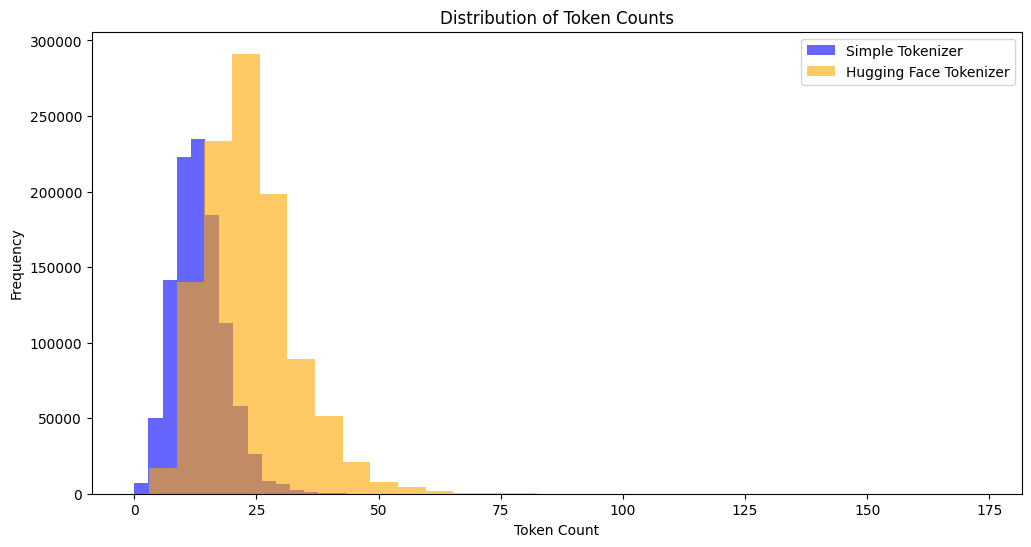

In [98]:
# Plot token count distributions
plt.figure(figsize=(12, 6))
plt.hist(df["simple_token_count"], bins=30, alpha=0.6, label="Simple Tokenizer", color="blue")
plt.hist(df["hf_token_count"], bins=30, alpha=0.6, label="Hugging Face Tokenizer", color="orange")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.title("Distribution of Token Counts")
plt.legend()
plt.show()


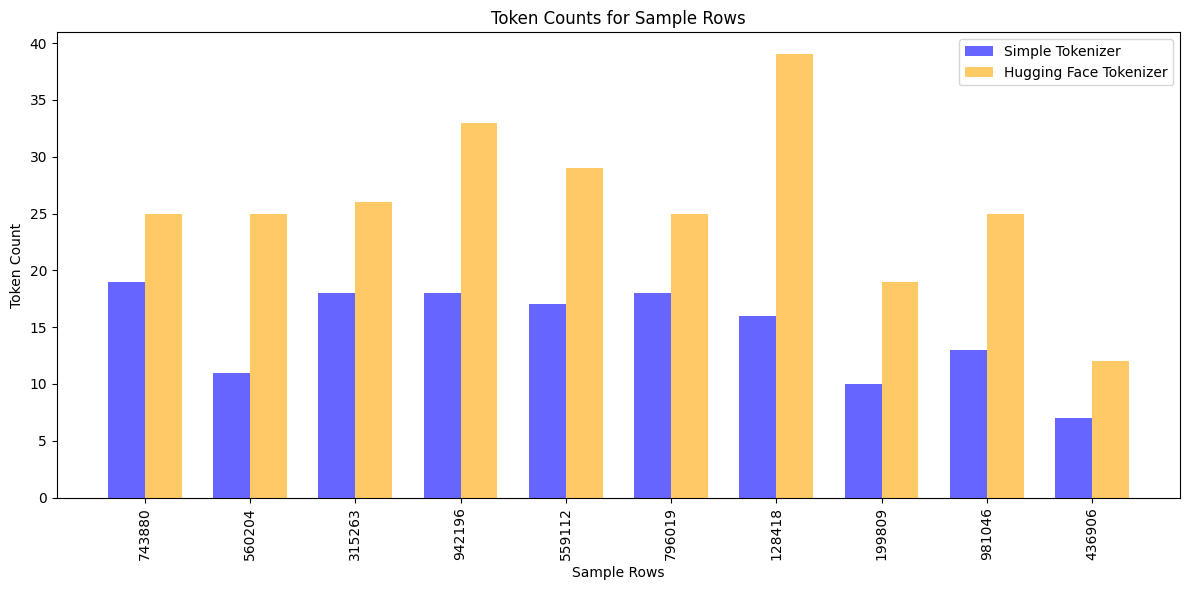

In [99]:
# Select a random sample of 10 rows
sample = df.sample(10, random_state=42)

# Plot token counts for the sample
x = range(len(sample))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, sample["simple_token_count"], width=width, label="Simple Tokenizer", color="blue", alpha=0.6)
plt.bar([i + width for i in x], sample["hf_token_count"], width=width, label="Hugging Face Tokenizer", color="orange", alpha=0.6)
plt.xlabel("Sample Rows")
plt.ylabel("Token Count")
plt.title("Token Counts for Sample Rows")
plt.xticks([i + width / 2 for i in x], sample.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


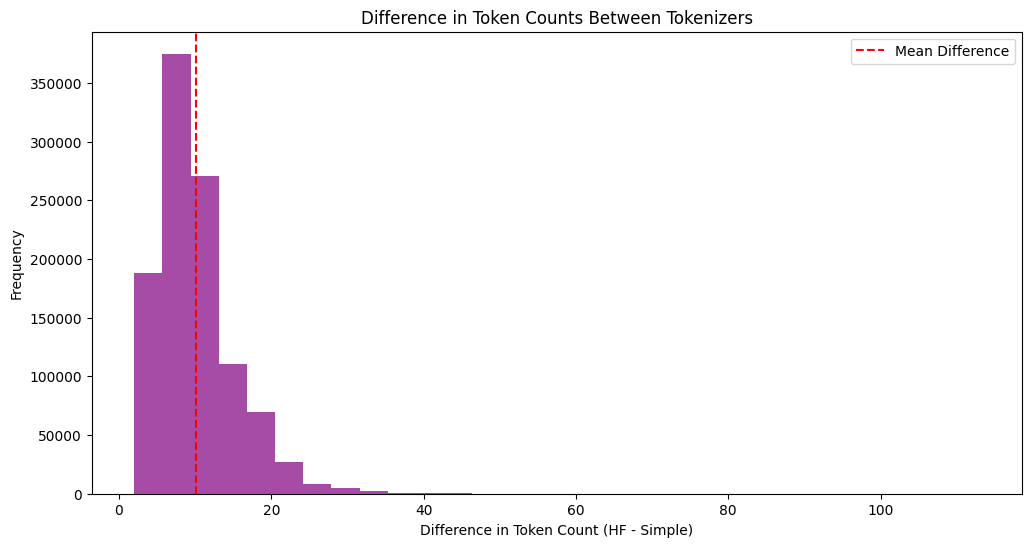

In [28]:
# Compute token count differences
df["token_count_difference"] = df["hf_token_count"] - df["simple_token_count"]

# Plot token count differences
plt.figure(figsize=(12, 6))
plt.hist(df["token_count_difference"], bins=30, color="purple", alpha=0.7)
plt.axvline(df["token_count_difference"].mean(), color="red", linestyle="--", label="Mean Difference")
plt.xlabel("Difference in Token Count (HF - Simple)")
plt.ylabel("Frequency")
plt.title("Difference in Token Counts Between Tokenizers")
plt.legend()
plt.show()


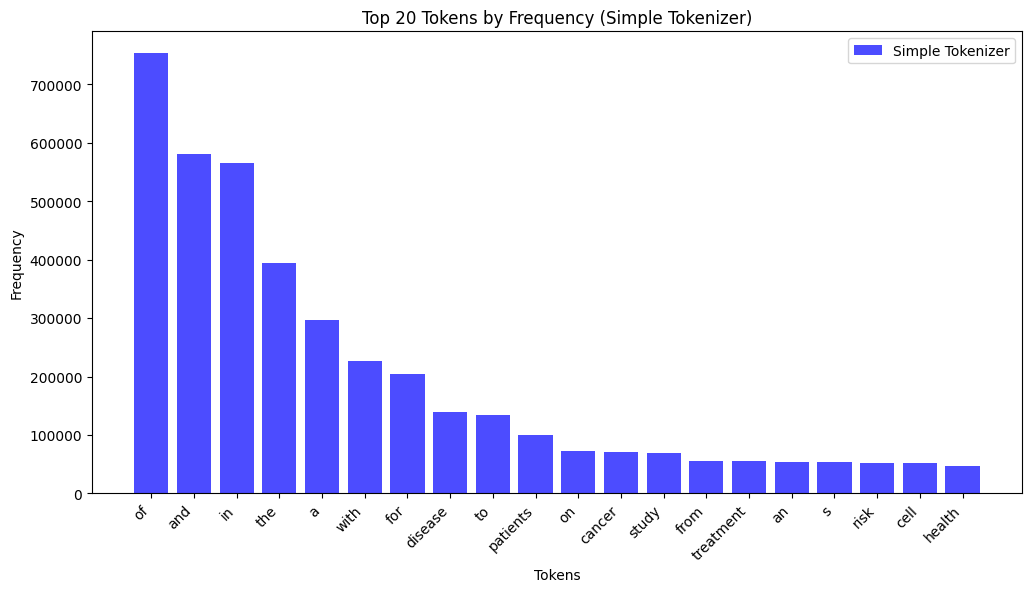

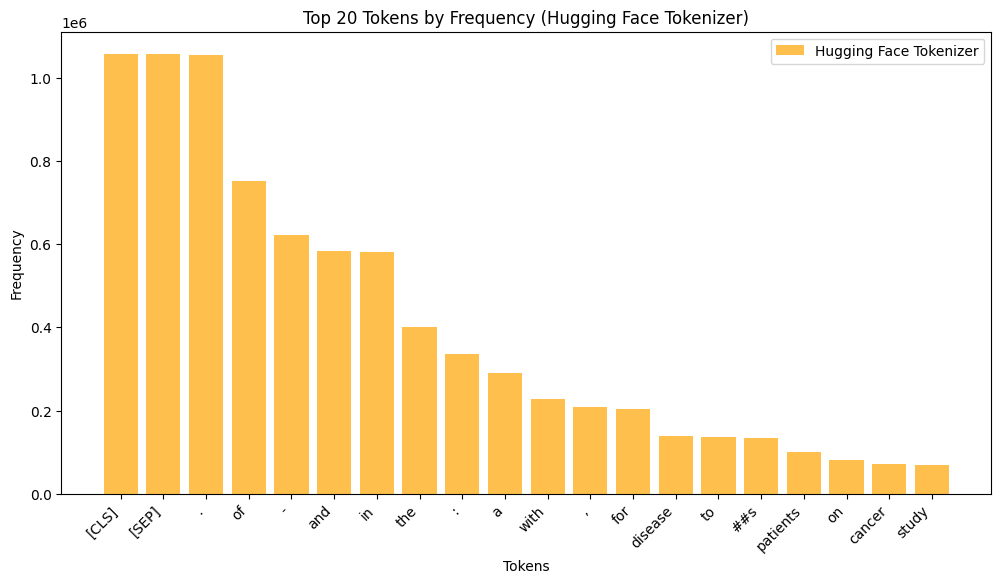

In [103]:
from collections import Counter

# Flatten token lists and calculate frequencies
simple_token_flat = [token for tokens in df["title_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["title_tokens_hf"] for token in tokens]

# Get top 20 tokens by frequency
simple_token_freq = Counter(simple_token_flat).most_common(20)
hf_token_freq = Counter(hf_token_flat).most_common(20)

# Plot token frequency for Simple Tokenizer
plt.figure(figsize=(12, 6))
simple_tokens, simple_freqs = zip(*simple_token_freq)
plt.bar(simple_tokens, simple_freqs, color="blue", alpha=0.7, label="Simple Tokenizer")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.title("Top 20 Tokens by Frequency (Simple Tokenizer)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

# Plot token frequency for Hugging Face Tokenizer
plt.figure(figsize=(12, 6))
hf_tokens, hf_freqs = zip(*hf_token_freq)
plt.bar(hf_tokens, hf_freqs, color="orange", alpha=0.7, label="Hugging Face Tokenizer")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.title("Top 20 Tokens by Frequency (Hugging Face Tokenizer)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()


In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens for TF-IDF analysis
df["simple_text"] = df["title_tokens_simple"].apply(lambda tokens: " ".join(tokens))
df["hf_text"] = df["title_tokens_hf"].apply(lambda tokens: " ".join(tokens))

# TF-IDF for Simple Tokenizer
tfidf_simple = TfidfVectorizer(max_features=20)
simple_tfidf_matrix = tfidf_simple.fit_transform(df["simple_text"])
simple_tfidf_df = pd.DataFrame(simple_tfidf_matrix.toarray(), columns=tfidf_simple.get_feature_names_out())

# TF-IDF for Hugging Face Tokenizer
tfidf_hf = TfidfVectorizer(max_features=20)
hf_tfidf_matrix = tfidf_hf.fit_transform(df["hf_text"])
hf_tfidf_df = pd.DataFrame(hf_tfidf_matrix.toarray(), columns=tfidf_hf.get_feature_names_out())

# TF-IDF for SpaCy fields
df["spacy_abstract_text"] = df["disease_abstract_spacy"].apply(lambda entities: " ".join(entities))
df["spacy_title_text"] = df["disease_title_spacy"].apply(lambda entities: " ".join(entities))

tfidf_spacy_abstract = TfidfVectorizer(max_features=20)
spacy_abstract_matrix = tfidf_spacy_abstract.fit_transform(df["spacy_abstract_text"])
spacy_abstract_tfidf_df = pd.DataFrame(spacy_abstract_matrix.toarray(), columns=tfidf_spacy_abstract.get_feature_names_out())

tfidf_spacy_title = TfidfVectorizer(max_features=20)
spacy_title_matrix = tfidf_spacy_title.fit_transform(df["spacy_title_text"])
spacy_title_tfidf_df = pd.DataFrame(spacy_title_matrix.toarray(), columns=tfidf_spacy_title.get_feature_names_out())

In [106]:
print("TF-IDF Matrix (SpaCy Abstract):")
spacy_abstract_tfidf_df.head()

TF-IDF Matrix (SpaCy Abstract):


and  breast  cancer  chronic  death  depression  diabetes   disease  \
0  0.000000     0.0     0.0      0.0    0.0         0.0       0.0  0.480504   
1  0.000000     0.0     0.0      0.0    0.0         0.0       0.0  0.000000   
2  0.000000     0.0     0.0      0.0    0.0         0.0       0.0  0.000000   
3  0.463474     0.0     0.0      0.0    0.0         0.0       0.0  0.766654   
4  0.000000     0.0     0.0      0.0    0.0         0.0       0.0  0.167276   

   diseases  disorders  failure  heart  hypertension  infection  infections  \
0       0.0        0.0  0.00000    0.0           0.0        0.0         0.0   
1       0.0        0.0  0.00000    0.0           0.0        0.0         0.0   
2       0.0        0.0  0.00000    0.0           0.0        0.0         0.0   
3       0.0        0.0  0.00000    0.0           0.0        0.0         0.0   
4       0.0        0.0  0.98591    0.0           0.0        0.0         0.0   

   pain  stroke  syndrome     tumor  tumors  
0   0.0     0.0  0.876993  0.000000     0.0  
1   0.0     0.0  0.000000  0.000000     0.0  
2   0.0     0.0  0.000000  0.000000     0.0  
3   0.0     0.0  0.000000  0.444334     0.0  
4   0.0     0.0  0.000000  0.000000     0.0

In [107]:
print("\nTF-IDF Matrix (SpaCy Title):")
spacy_title_tfidf_df.head()


TF-IDF Matrix (SpaCy Title):


acute  alzheimer  and  breast  cancer  carcinoma  cell  chronic  diabetes  \
0    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   
1    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   
2    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   
3    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   
4    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   

   disease  disorder  failure  heart  infection  pain  parkinson  prostate  \
0      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   
1      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   
2      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   
3      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   
4      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   

   pulmonary  syndrome  tumor  
0        0.0       0.0    0.0  
1        0.0       0.0    0.0  
2        0.0       0.0    0.0  
3        0.0       0.0    0.0  
4        0.0       0.0    0.0

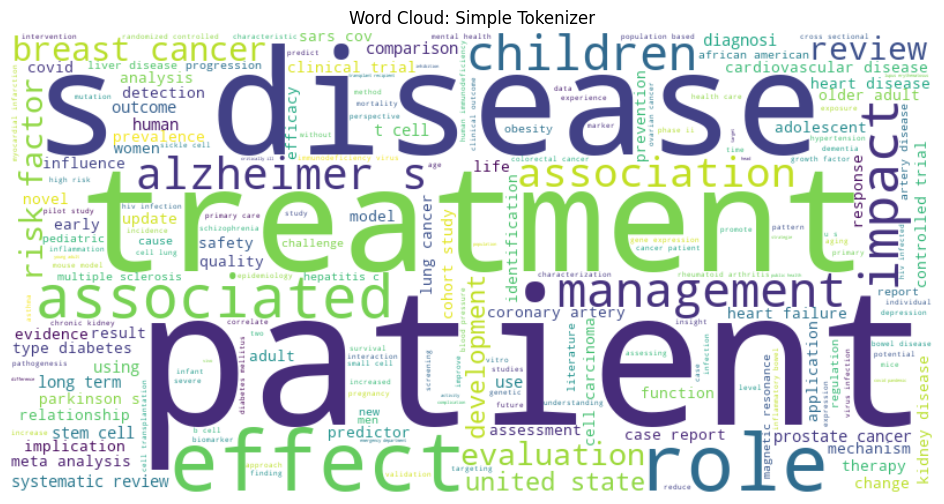

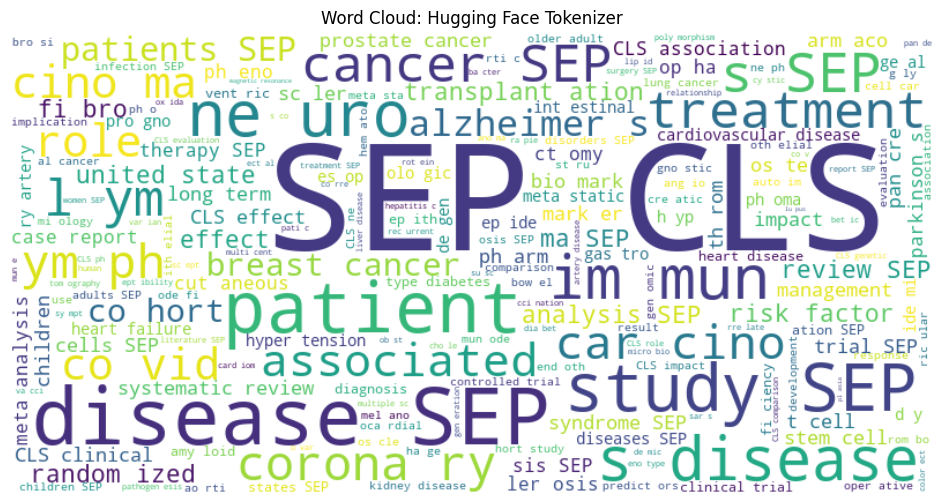

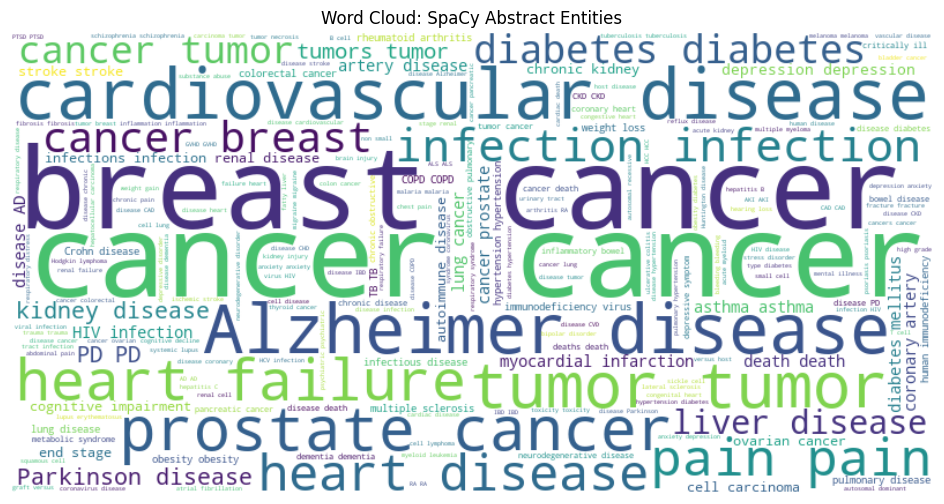

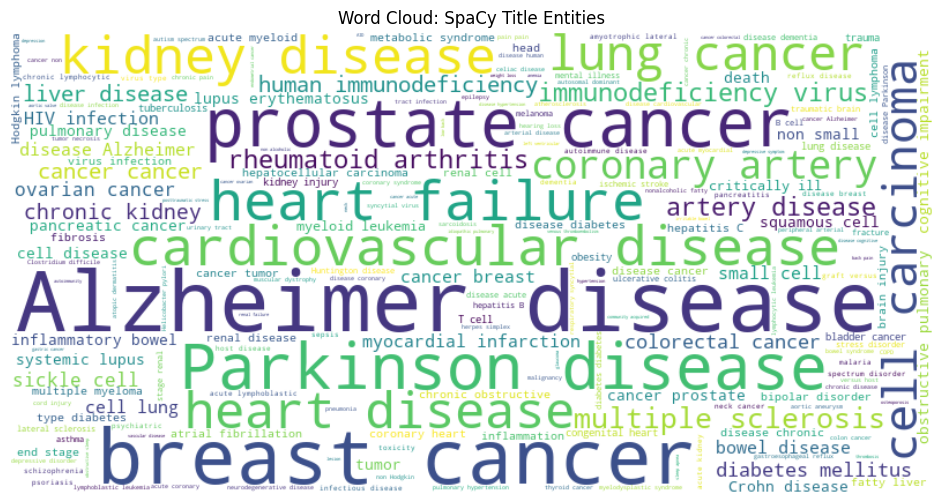

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word clouds for tokenized data
simple_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(simple_token_flat))
hf_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(hf_token_flat))

# Word clouds for SpaCy entities
spacy_abstract_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["spacy_abstract_text"]))
spacy_title_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["spacy_title_text"]))

# Plotting
plt.figure(figsize=(12, 6))
plt.imshow(simple_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Simple Tokenizer")
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(hf_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Hugging Face Tokenizer")
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(spacy_abstract_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: SpaCy Abstract Entities")
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(spacy_title_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: SpaCy Title Entities")
plt.show()


In [27]:
#df

### WORDS PER EACH YEAR, ANALYSIS

In [110]:
# Ensure the 'parsed_date' is datetime
df["year"] = df["parsed_date"].dt.year

# Flatten and group entities by year
abstract_entities_by_year = df.groupby("year")["disease_abstract_spacy"].apply(lambda x: [entity for entities in x for entity in entities])
title_entities_by_year = df.groupby("year")["disease_title_spacy"].apply(lambda x: [entity for entities in x for entity in entities])

# Count top entities per year
abstract_top_entities_by_year = abstract_entities_by_year.apply(lambda entities: Counter(entities).most_common(5))
title_top_entities_by_year = title_entities_by_year.apply(lambda entities: Counter(entities).most_common(5))

print("Top Entities by Year (Abstract):")
print(abstract_top_entities_by_year)

print("\nTop Entities by Year (Title):")
print(title_top_entities_by_year)


Top Entities by Year (Abstract):
year
1995    [(tumor, 1799), (infection, 1617), (death, 118...
1996    [(tumor, 2500), (infection, 1877), (cancer, 16...
1997    [(tumor, 2561), (infection, 1935), (death, 178...
1998    [(tumor, 2847), (infection, 2025), (death, 194...
1999    [(tumor, 2440), (infection, 1868), (death, 179...
2000    [(tumor, 2968), (death, 2302), (infection, 224...
2001    [(tumor, 3072), (infection, 2428), (cancer, 22...
2002    [(tumor, 3236), (cancer, 2577), (death, 2466),...
2003    [(tumor, 3334), (cancer, 3026), (pain, 2826), ...
2004    [(tumor, 3654), (cancer, 3255), (pain, 2905), ...
2005    [(tumor, 3877), (cancer, 3760), (pain, 3205), ...
2006    [(tumor, 3882), (cancer, 3717), (death, 3153),...
2007    [(cancer, 4258), (tumor, 4015), (diabetes, 330...
2008    [(cancer, 4377), (tumor, 4161), (pain, 3600), ...
2009    [(cancer, 4361), (tumor, 4301), (pain, 3505), ...
2010    [(cancer, 5054), (tumor, 4624), (pain, 3988), ...
2011    [(cancer, 4953), (tumor, 4

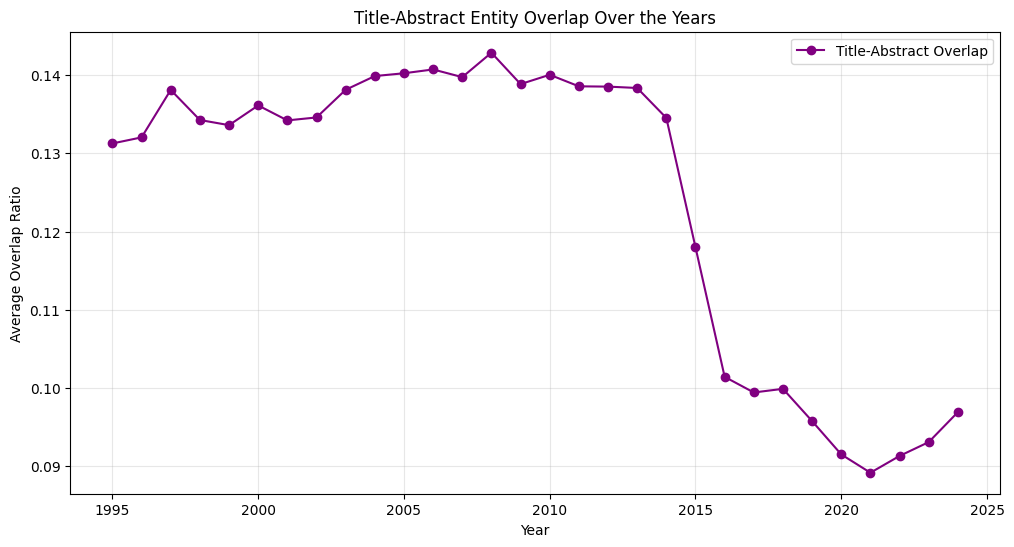

In [117]:
# Calculate overlap ratio
df["overlap_ratio"] = df.apply(
    lambda row: len(set(row["disease_title_spacy"]) & set(row["disease_abstract_spacy"])) / max(1, len(set(row["disease_title_spacy"]) | set(row["disease_abstract_spacy"]))),
    axis=1,
)

# Average overlap by year
overlap_by_year = df.groupby(df["parsed_date"].dt.year)["overlap_ratio"].mean()

# Plot overlap
plt.figure(figsize=(12, 6))
plt.plot(overlap_by_year.index, overlap_by_year, marker="o", color="purple", label="Title-Abstract Overlap")
plt.xlabel("Year")
plt.ylabel("Average Overlap Ratio")
plt.title("Title-Abstract Entity Overlap Over the Years")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


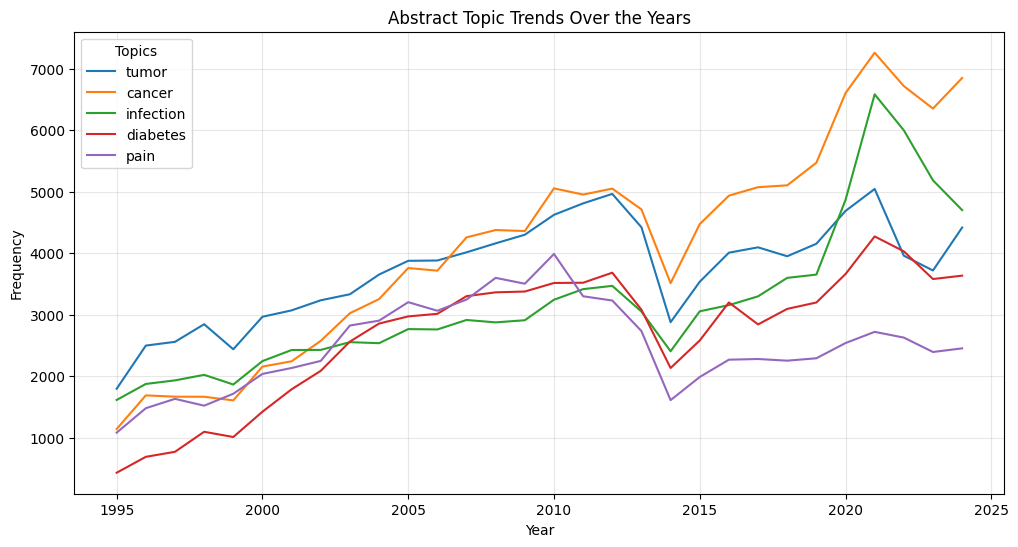

In [118]:
from collections import Counter

# Group by year for abstract entities
abstract_entities_by_year = df.groupby(df["parsed_date"].dt.year)["disease_abstract_spacy"].apply(
    lambda x: [entity for entities in x for entity in entities]
)
abstract_counts_by_year = abstract_entities_by_year.apply(lambda entities: Counter(entities))

# Define topics of interest
topics = ["tumor", "cancer", "infection", "diabetes", "pain"]

# Create a DataFrame for abstract trends
abstract_topic_trends = pd.DataFrame({
    topic: abstract_counts_by_year.apply(lambda counts: counts.get(topic, 0)) for topic in topics
})
abstract_topic_trends.index.name = "Year"

# Plot abstract trends
plt.figure(figsize=(12, 6))
for topic in topics:
    plt.plot(abstract_topic_trends.index, abstract_topic_trends[topic], label=topic)

plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Abstract Topic Trends Over the Years")
plt.legend(title="Topics")
plt.grid(alpha=0.3)
plt.show()


Entity Overlap Between Title and Abstract:
entity_overlap
0    637444
1    352330
2     59865
3      7198
4       889
5       117
6        20
7         5
8         3
Name: count, dtype: int64


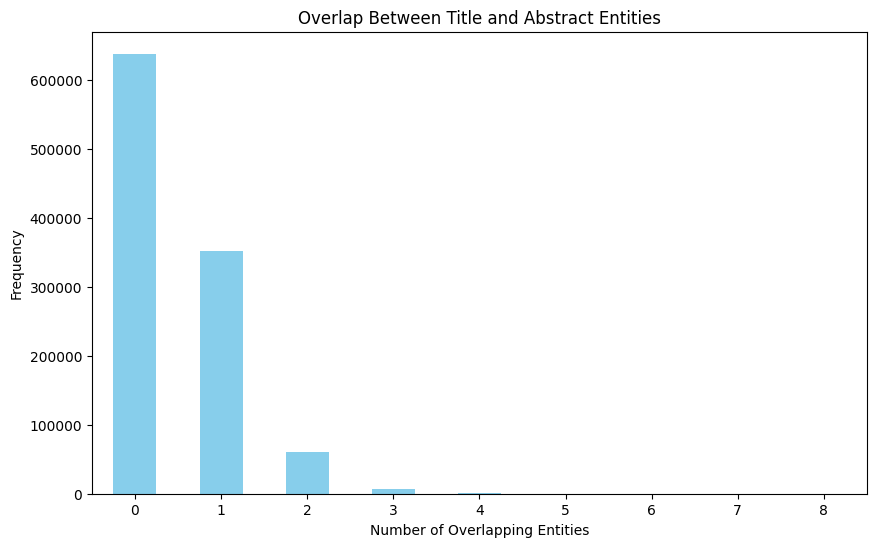

In [113]:
# Check overlap between title and abstract entities
df["entity_overlap"] = df.apply(
    lambda row: len(set(row["disease_title_spacy"]) & set(row["disease_abstract_spacy"])),
    axis=1,
)

# Value counts for the overlap
overlap_counts = df["entity_overlap"].value_counts()
print("Entity Overlap Between Title and Abstract:")
print(overlap_counts)

# Visualize overlap
plt.figure(figsize=(10, 6))
overlap_counts.plot(kind="bar", color="skyblue")
plt.xlabel("Number of Overlapping Entities")
plt.ylabel("Frequency")
plt.title("Overlap Between Title and Abstract Entities")
plt.xticks(rotation=0)
plt.show()


In [120]:
# Flatten entities for titles and abstracts
title_entity_counts = Counter(
    [entity for entities in df["disease_title_spacy"] for entity in entities]
)
abstract_entity_counts = Counter(
    [entity for entities in df["disease_abstract_spacy"] for entity in entities]
)

# Create DataFrames for better visualization
title_counts_df = pd.DataFrame.from_dict(title_entity_counts, orient="index", columns=["count"]).sort_values(by="count", ascending=False)
abstract_counts_df = pd.DataFrame.from_dict(abstract_entity_counts, orient="index", columns=["count"]).sort_values(by="count", ascending=False)

print("Value Counts Table for Title Entities:")
print(title_counts_df.head(100))

print("\nValue Counts Table for Abstract Entities:")
print(abstract_counts_df.head(100))


Value Counts Table for Title Entities:
                      count
cancer                13221
breast cancer          9851
Alzheimer's disease    9762
diabetes               8792
prostate cancer        7240
...                     ...
osteoporosis            947
migraine                922
cord injury             904
head and neck cancer    901
Prostate Cancer         894

[100 rows x 1 columns]

Value Counts Table for Abstract Entities:
                      count
cancer               123627
tumor                111922
infection             95447
death                 89192
diabetes              80831
...                     ...
migraine               8869
headache               8835
depressive symptoms    8808
tumour                 8779
diabetic               8399

[100 rows x 1 columns]


In [ ]:
title_counts_df

In [ ]:
abstract_counts_df


In [121]:
from collections import Counter

# Flatten entities for titles and abstracts
title_entity_counts = Counter([entity for entities in df["disease_title_spacy"] for entity in entities])
abstract_entity_counts = Counter([entity for entities in df["disease_abstract_spacy"] for entity in entities])

# Convert to DataFrame for visualization
title_counts_df = pd.DataFrame.from_dict(title_entity_counts, orient="index", columns=["count"]).sort_values(by="count", ascending=False)
abstract_counts_df = pd.DataFrame.from_dict(abstract_entity_counts, orient="index", columns=["count"]).sort_values(by="count", ascending=False)

print("Top 10 Title Entities by Count:")
print(title_counts_df.head(10))

print("\nTop 10 Abstract Entities by Count:")
print(abstract_counts_df.head(10))


Top 10 Title Entities by Count:
                        count
cancer                  13221
breast cancer            9851
Alzheimer's disease      9762
diabetes                 8792
prostate cancer          7240
infection                6507
tumor                    6203
Parkinson's disease      5841
Cancer                   5561
cardiovascular disease   4962

Top 10 Abstract Entities by Count:
               count
cancer        123627
tumor         111922
infection      95447
death          89192
diabetes       80831
pain           74936
depression     55449
inflammation   53431
hypertension   52465
tumors         51951


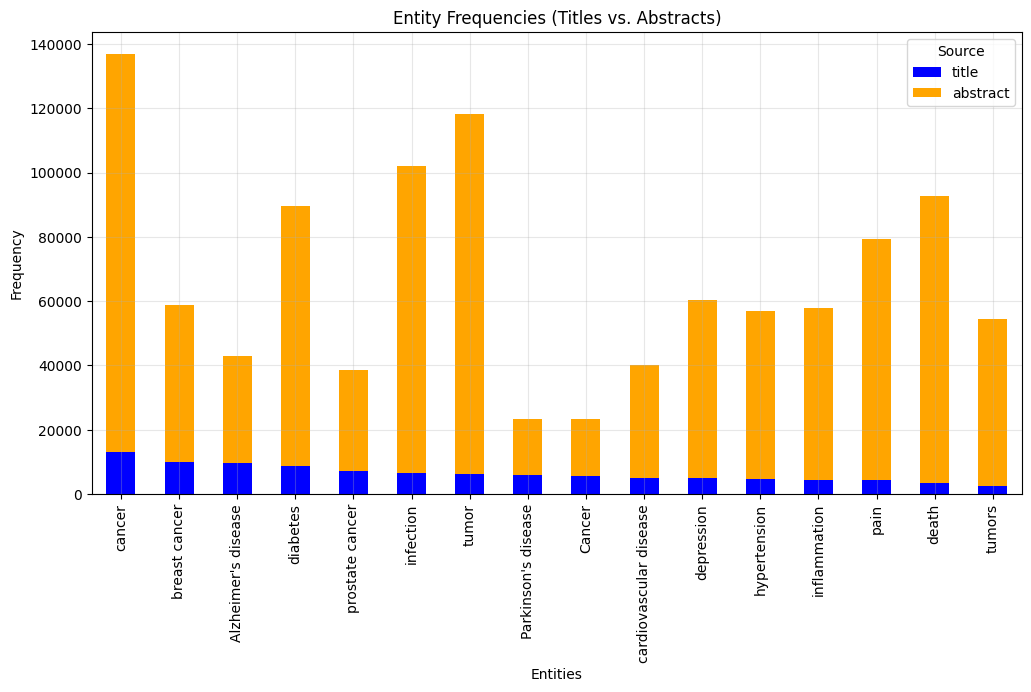

In [123]:
# Convert set to list for indexing
top_entities_list = list(top_entities)

# Combine counts for the top entities
combined_counts = pd.DataFrame({
    "title": title_counts_df.loc[top_entities_list]["count"].fillna(0),
    "abstract": abstract_counts_df.loc[top_entities_list]["count"].fillna(0),
}).sort_values(by=["title", "abstract"], ascending=False)

# Stacked bar chart
combined_counts.plot(kind="bar", stacked=True, figsize=(12, 6), color=["blue", "orange"])
plt.title("Entity Frequencies (Titles vs. Abstracts)")
plt.xlabel("Entities")
plt.ylabel("Frequency")
plt.legend(title="Source")
plt.grid(alpha=0.3)
plt.show()


In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare data for TF-IDF
df["title_text"] = df["disease_title_spacy"].apply(lambda x: " ".join(x))
df["abstract_text"] = df["disease_abstract_spacy"].apply(lambda x: " ".join(x))

# TF-IDF for Titles
tfidf_vectorizer = TfidfVectorizer(max_features=20)
tfidf_title_matrix = tfidf_vectorizer.fit_transform(df["title_text"])
tfidf_title_df = pd.DataFrame(tfidf_title_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# TF-IDF for Abstracts
tfidf_abstract_matrix = tfidf_vectorizer.fit_transform(df["abstract_text"])
tfidf_abstract_df = pd.DataFrame(tfidf_abstract_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print("TF-IDF (Titles):")
print(tfidf_title_df.head())

print("\nTF-IDF (Abstracts):")
print(tfidf_abstract_df.head())


TF-IDF (Titles):
   acute  alzheimer  and  breast  cancer  carcinoma  cell  chronic  diabetes  \
0    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   
1    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   
2    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   
3    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   
4    0.0        0.0  0.0     0.0     0.0        0.0   0.0      0.0       0.0   

   disease  disorder  failure  heart  infection  pain  parkinson  prostate  \
0      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   
1      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   
2      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   
3      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   
4      0.0       0.0      0.0    0.0        0.0   0.0        0.0       0.0   

   pulmonary  syndrome  tumor  
0

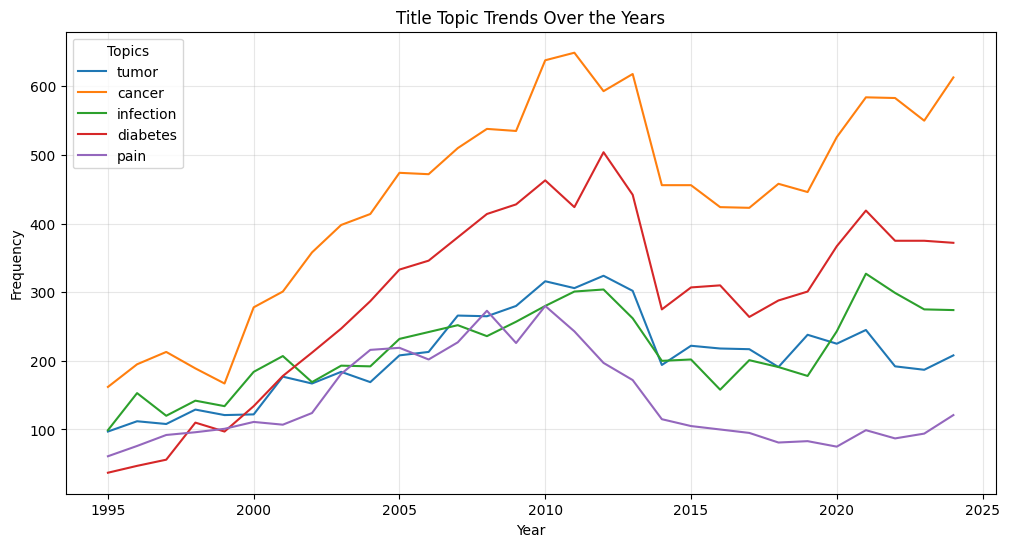

In [119]:
# Group by year for title entities
title_entities_by_year = df.groupby(df["parsed_date"].dt.year)["disease_title_spacy"].apply(
    lambda x: [entity for entities in x for entity in entities]
)
title_counts_by_year = title_entities_by_year.apply(lambda entities: Counter(entities))

# Create a DataFrame for title trends
title_topic_trends = pd.DataFrame({
    topic: title_counts_by_year.apply(lambda counts: counts.get(topic, 0)) for topic in topics
})
title_topic_trends.index.name = "Year"

# Plot title trends
plt.figure(figsize=(12, 6))
for topic in topics:
    plt.plot(title_topic_trends.index, title_topic_trends[topic], label=topic)

plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Title Topic Trends Over the Years")
plt.legend(title="Topics")
plt.grid(alpha=0.3)
plt.show()


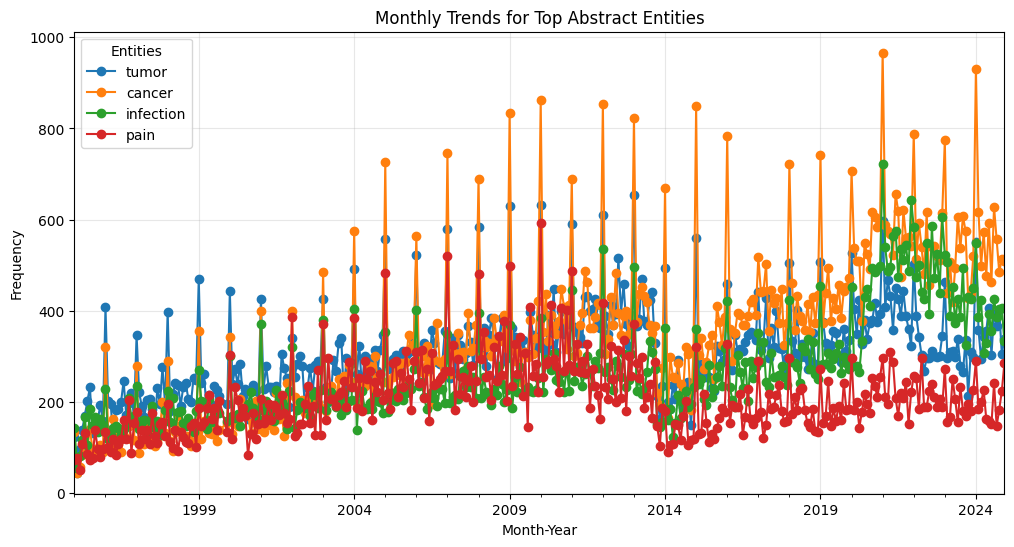

In [125]:
# Monthly trends for top terms
df["month_year"] = df["parsed_date"].dt.to_period("M")  # Group by month
monthly_entities = df.groupby("month_year")["disease_abstract_spacy"].apply(lambda x: [entity for entities in x for entity in entities])
monthly_counts = monthly_entities.apply(lambda entities: Counter(entities))

# Extract frequencies for top entities
monthly_top_entities = ["tumor", "cancer", "infection", "pain"]
monthly_trends = pd.DataFrame({
    term: monthly_counts.apply(lambda counts: counts.get(term, 0)) for term in monthly_top_entities
})

# Plot monthly trends
monthly_trends.plot(figsize=(12, 6), marker="o")
plt.title("Monthly Trends for Top Abstract Entities")
plt.xlabel("Month-Year")
plt.ylabel("Frequency")
plt.legend(title="Entities")
plt.grid(alpha=0.3)
plt.show()


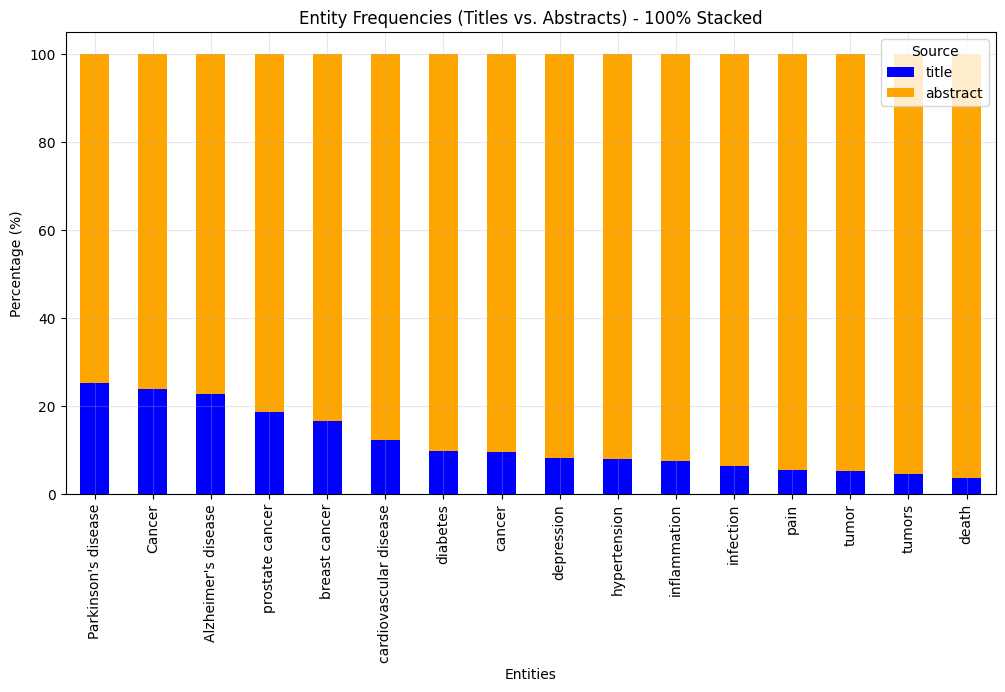

In [126]:
# Convert set to list for indexing
top_entities_list = list(top_entities)

# Combine counts for the top entities
combined_counts = pd.DataFrame({
    "title": title_counts_df.loc[top_entities_list]["count"].fillna(0),
    "abstract": abstract_counts_df.loc[top_entities_list]["count"].fillna(0),
})

# Normalize to 100% by dividing each value by the row sum
combined_counts_normalized = combined_counts.div(combined_counts.sum(axis=1), axis=0) * 100

# Sort the normalized counts (optional)
combined_counts_normalized = combined_counts_normalized.sort_values(by=["title", "abstract"], ascending=False)

# Stacked bar chart with 100% scaling
combined_counts_normalized.plot(kind="bar", stacked=True, figsize=(12, 6), color=["blue", "orange"])
plt.title("Entity Frequencies (Titles vs. Abstracts) - 100% Stacked")
plt.xlabel("Entities")
plt.ylabel("Percentage (%)")
plt.legend(title="Source")
plt.grid(alpha=0.3)
plt.show()


### Variable: `journal`

In [29]:
journal_counts = df["journal"].value_counts(dropna=False)
print("Top 20 journals:")
print(journal_counts.head(20))

Top 20 journals:
journal
Scientific reports                                                                                      8778
Clinical infectious diseases : an official publication of the Infectious Diseases Society of America    5953
Nature communications                                                                                   5537
International journal of molecular sciences                                                             4551
Journal of virology                                                                                     4061
Cancer                                                                                                  4046
The Journal of infectious diseases                                                                      4021
The American journal of cardiology                                                                      3867
The Journal of biological chemistry                                                                    

In [12]:
# # long time to process it but overall cutoff does not make make new categories or make less categories so we will be staying with preprocessed journals
# import pandas as pd
# import difflib

# def basic_clean_journal(j):
#     if not isinstance(j, str):
#         return str(j)
#     return j.lower().strip().replace(".", "")

# def fuzzy_match_journal(j, known_journals, cutoff=0.8):
#     best = difflib.get_close_matches(j, known_journals, n=1, cutoff=cutoff)
#     return best[0] if best else j

# # 1) Basic cleaning
# df["journal_clean_basic"] = df["journal"].apply(basic_clean_journal)

# # 2) Original number of categories
# original_unique_categories = df["journal_clean_basic"].nunique()
# print("Original number of categories (cleaned):", original_unique_categories)

# # 3) Build known_journals from unique cleaned names
# known_journals = df["journal_clean_basic"].dropna().unique().tolist()

# # 4) Fuzzy match each row
# df["journal_fuzzy"] = df["journal_clean_basic"].apply(
#     lambda x: fuzzy_match_journal(x, known_journals, cutoff=0.4)
# )

# # 5) Number of categories AFTER fuzzy unification
# fuzzy_unique_categories = df["journal_fuzzy"].nunique()
# print("Number of categories after fuzzy unification:", fuzzy_unique_categories)

# # 6) Compare
# df["journal_match_same"] = (df["journal_clean_basic"] == df["journal_fuzzy"])


In [15]:
## Drop the unwanted columns 
#df = df.drop(columns=["journal_clean_basic", "journal_fuzzy", "journal_match_same"]).copy()

C:\Users\macie\AppData\Local\Temp\ipykernel_30340\3917490531.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


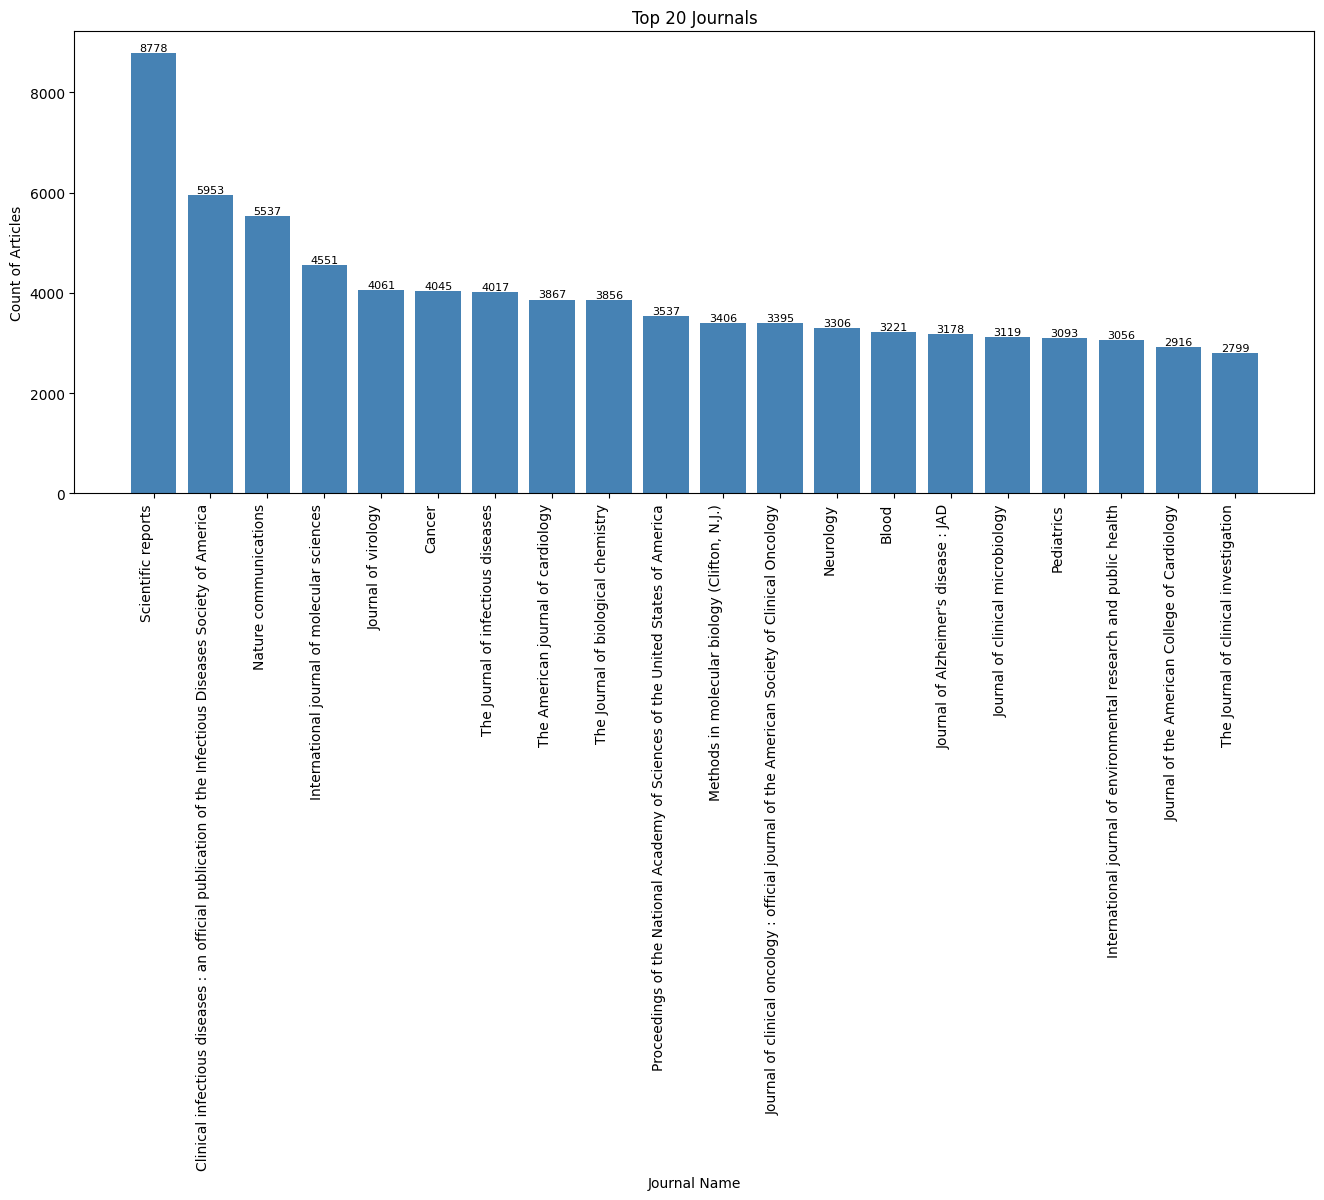

In [39]:
import matplotlib.pyplot as plt

journal_counts = df["journal"].value_counts().head(20)

plt.figure(figsize=(16, 6))
bars = plt.bar(range(len(journal_counts)), journal_counts.values, color='steelblue')

# X-ticks
plt.xticks(range(len(journal_counts)), journal_counts.index, rotation=90, ha='right')
plt.title("Top 20 Journals")
plt.xlabel("Journal Name")
plt.ylabel("Count of Articles")

# Label each bar with its count
for i, rect in enumerate(bars):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height,
             f"{int(height)}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
journal_counts = df["journal"].value_counts().head(20)

plt.figure(figsize=(12,6))
bars = plt.bar(range(len(journal_counts)), journal_counts.values, color='steelblue')
plt.xticks(range(len(journal_counts)), journal_counts.index, rotation=45, ha='right')

for i, rect in enumerate(bars):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height,
             f"{int(height)}", ha='center', va='bottom', fontsize=8)

plt.title("Top 20 Journals (with counts)")
plt.xlabel("Journal")
plt.ylabel("Count of Articles")
plt.tight_layout()
plt.show()


### Variable: `abstract`

In [ ]:
def simple_tokenize(text):
    """
    Example of a basic approach:
    - Lowercase
    - Remove punctuation or digits if you want
    - Split on whitespace
    """
    import re
    if not isinstance(text, str) or not text.strip():
        return []
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.split()

from transformers import AutoTokenizer

# Hugging Face tokenizer from, e.g. "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def huggingface_tokenize(text, max_len=512):
    """
    Use the Hugging Face tokenizer to split text into tokens (subwords).
    We'll specify truncation to avoid index errors if text is too long.
    """
    if not isinstance(text, str) or not text.strip():
        return []
    # We'll do 'tokenize' approach, but we can also do 'encode' with truncation=True
    # For demonstration, let's do 'encode' so we can specify max_length.
    # This returns list of IDs, we can convert them back to tokens if we want.
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=False
    )
    # Now convert IDs back to tokens to see subwords
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"])
    return tokens

# Example usage on df["abstract"]
df["abstract_tokens_simple"] = df["abstract"].apply(simple_tokenize)

# Hugging Face subword approach, with truncation
df["abstract_tokens_hf"] = df["abstract"].apply(lambda txt: huggingface_tokenize(txt, max_len=512))


### Variable: `authors`

In [ ]:
df["authors_list"] = df["authors"].fillna("").str.split(";").apply(
    lambda x: [a.strip() for a in x if a.strip()]
)

In [ ]:
import pandas as pd
from collections import Counter

df["authors_list"] = (
    df["authors"]
    .fillna("")
    .str.split(";")
    .apply(lambda x: [a.strip() for a in x if a.strip()])
)

# Now each row has a Python list of authors
author_counter = Counter()

for authors in df["authors_list"]:
    author_counter.update(authors)

# Inspect top 20 authors
for author, freq in author_counter.most_common(20):
    print(author, freq)


### Variable: `affiliations`

In [ ]:
df["affiliations_list"] = df["affiliations"].fillna("").str.split(";").apply(
    lambda x: [aff.strip() for aff in x if aff.strip()]
)


In [ ]:
aff_counter = df["affiliations"].fillna("").value_counts()
print("Top 20 affiliations:")
print(aff_counter)


In [ ]:
aff_freq = df["affiliations"].value_counts(dropna=False)
print("Number of unique affiliations:", len(aff_freq))
print("Top 20 affiliation strings:")
print(aff_freq.head(20))


### Variable: `mesh_terms`

In [4]:
# df["mesh_list"] = df["mesh_terms"].fillna("").str.split(";").apply(
#     lambda x: [m.strip() for m in x if m.strip()]
# )
df["mesh_list"] = (
    df["mesh_terms"]
    .fillna("")  # replace NaN with empty string
    .str.split(";")
    .apply(lambda x: [m.strip() for m in x if m.strip()])  # strip spaces, remove empties
)


In [5]:
from collections import Counter

mesh_counter = Counter()
for mesh_terms in df["mesh_list"]:
    # mesh_terms is a list, e.g. ["Adolescent", "Adult", ...]
    mesh_counter.update(mesh_terms)

# Turn counter into a DataFrame sorted by frequency
mesh_freq_df = pd.DataFrame(mesh_counter.most_common(), columns=["mesh_term", "count"])
mesh_freq_df.head(20)


mesh_term    count
0                      Humans  1057871
1                      Female   472540
2                        Male   432617
3                 Middle Aged   289180
4                       Adult   283915
5                        Aged   227184
6                     Animals   181045
7                  Adolescent   114072
8                Risk Factors   102561
9                       Child    96124
10          Treatment Outcome    95126
11      Retrospective Studies    93845
12          Aged, 80 and over    84418
13              United States    83743
14                       Mice    67297
15                Young Adult    64885
16  Severity of Illness Index    53709
17           Child, Preschool    52504
18        Prospective Studies    46072
19          Follow-Up Studies    45577

In [6]:
# Explode the list so each row in df_exploded is one MeSH term
df_exploded = df.explode("mesh_list")
# Then we can do a value_counts on the single item
mesh_freq = df_exploded["mesh_list"].value_counts(dropna=False)
print("Number of unique MeSH terms:", len(mesh_freq))
print("Top 20 MeSH terms:")
print(mesh_freq.head(20))


Number of unique MeSH terms: 27087
Top 20 MeSH terms:
mesh_list
Humans                       1057871
Female                        472540
Male                          432617
Middle Aged                   289180
Adult                         283915
Aged                          227184
Animals                       181045
Adolescent                    114072
Risk Factors                  102561
Child                          96124
Treatment Outcome              95126
Retrospective Studies          93845
Aged, 80 and over              84418
United States                  83743
Mice                           67297
Young Adult                    64885
Severity of Illness Index      53709
Child, Preschool               52504
Prospective Studies            46072
Follow-Up Studies              45577
Name: count, dtype: int64


In [7]:
# import pandas as pd
# from collections import Counter
# import time

# def author_mesh_combos_in_chunks(df, chunk_size=100_000):
#     """
#     For each chunk of df, explode 'authors_list' and 'mesh_list'
#     and compute counts of (author, mesh) combos, then combine.
#     """
#     combo_counter = Counter()
#     num_rows = len(df)

#     total_start = time.time()

#     for start in range(0, num_rows, chunk_size):
#         end = min(start + chunk_size, num_rows)
#         chunk = df.iloc[start:end].copy()
        
#         # Explode authors_list, then mesh_list
#         chunk = chunk.explode("authors_list")
#         chunk = chunk.explode("mesh_list")
        
#         # Update counter
#         for author, mesh in zip(chunk["authors_list"], chunk["mesh_list"]):
#             if pd.isna(author) or pd.isna(mesh):
#                 continue
#             combo_counter[(author, mesh)] += 1

#         print(f"Processed rows {start} to {end} → combos so far: {len(combo_counter)}. "
#               f"Elapsed: {time.time() - total_start:.2f}s")

#     return combo_counter

# # Usage:
# combos = author_mesh_combos_in_chunks(df, chunk_size=100000)
# # Then convert combos to a DataFrame if desired:
# combos_df = pd.DataFrame([(*k, v) for k, v in combos.items()], columns=["author","mesh","count"])
# combos_df.sort_values("count", ascending=False).head(20)


In [ ]:
df_mesh_list = df[['uid', 'mesh_list']].copy()

In [12]:
import os 

# Folder and file paths
folder_path = "Data/2.Processed/ModellingData"

file_name_mesh_list = "P2_mesh_list.parquet"

file_path_mesh_list = os.path.join(folder_path, file_name_mesh_list)

# 1. Save the DataFrame as a single Parquet file
df_mesh_list.to_parquet(file_path_mesh_list, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_mesh_list}")

DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P2_mesh_list.parquet


In [ ]:
###############################################################################
# COMPLETE CODE: CHUNK-BASED DISEASE EXTRACTION (BC5CDR) + TIME LEFT ESTIMATE
###############################################################################

import os
import time
import scispacy
import spacy
import pandas as pd
from tqdm.auto import tqdm

###############################################################################
# 1) LOAD BC5CDR MODEL, DISABLING COMPONENTS FOR SPEED
###############################################################################
try:
    nlp_bc5cdr = spacy.load(
        "en_ner_bc5cdr_md", 
        disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
    )
except Exception as e:
    print("Could not load 'en_ner_bc5cdr_md'. Make sure you installed:")
    print("  pip install scispacy")
    print("  pip install en_ner_bc5cdr_md-0.5.4.tar.gz (or your local path)")
    raise e

def extract_diseases_spacy(doc):
    """
    Extract disease mentions from BC5CDR model. (ent.label_ in {CHEMICAL, DISEASE})
    We only keep label == 'DISEASE'.
    """
    diseases = []
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            diseases.append(ent.text)
    return diseases

###############################################################################
# 2) CHUNK PROCESSING WITH RESUME & TIME REMAIN ESTIMATE
###############################################################################
def process_diseases_in_chunks_with_resume(
    df,
    text_col="title",
    chunk_size=10_000,
    batch_size=32,
    save_path="partial_bc5cdr.parquet"
):
    """
    - df: main DataFrame
    - text_col: column with text to process
    - chunk_size: # of rows per chunk
    - batch_size: # docs per nlp.pipe() batch
    - save_path: Parquet file to store partial/final results

    1) Resumes from an existing partial file if it exists.
    2) Processes row by row in chunks, each chunk using spaCy's pipe for faster NER.
    3) Shows a progress bar + estimates time left based on chunk durations.
    4) Saves partial results after each chunk, then a final full save.
    5) The disease mentions get stored in df["disease_entities_spacy"].
    """
    # Reset index so row order is stable
    df = df.reset_index(drop=True)

    # Initialize the column if absent
    if "disease_entities_spacy" not in df.columns:
        df["disease_entities_spacy"] = None

    # Figure out how many rows are already done if partial file is found
    start_idx = 0
    if os.path.exists(save_path):
        try:
            partial_df = pd.read_parquet(save_path)
            if "disease_entities_spacy" in partial_df.columns:
                df["disease_entities_spacy"] = partial_df["disease_entities_spacy"]
                done_mask = df["disease_entities_spacy"].notna()
                done_rows = done_mask.sum()
                start_idx = done_rows
                print(f"Resuming from row {start_idx} based on partial file {save_path}.")
            else:
                print(f"WARNING: {save_path} lacks 'disease_entities_spacy'. Starting fresh.")
        except Exception as e:
            print(f"Error reading partial file {save_path}: {e}")
            print("Starting from scratch.")
    else:
        print("No partial file found. Starting from scratch.")

    total_rows = len(df)
    if start_idx >= total_rows:
        print(f"All {total_rows} rows processed. Nothing to do.")
        return df

    # Calculate how many chunks remain
    remaining = total_rows - start_idx
    num_chunks = (remaining + chunk_size - 1) // chunk_size
    print(f"Starting chunked processing from row {start_idx}/{total_rows}, "
          f"{remaining} rows left, {num_chunks} chunks.\n")

    cur_row = start_idx
    chunk_times = []  # keep track of each chunk's duration to estimate time left

    # Initialize the progress bar
    with tqdm(total=num_chunks, desc="Processing Chunks", unit="chunk") as pbar:
        for i in range(num_chunks):
            chunk_start_time = time.time()

            end_idx = min(cur_row + chunk_size, total_rows)
            chunk = df.iloc[cur_row:end_idx].copy()
            texts = chunk[text_col].fillna("").tolist()

            # We'll store the results
            results = []

            # Use spaCy pipe in batch
            for doc in nlp_bc5cdr.pipe(texts, batch_size=batch_size):
                diseases = extract_diseases_spacy(doc)
                results.append(diseases)

            # Store in chunk and main df
            chunk["disease_entities_spacy"] = results
            df.iloc[cur_row:end_idx, df.columns.get_loc("disease_entities_spacy")] = chunk["disease_entities_spacy"]

            # Partial save
            df.iloc[:end_idx].to_parquet(save_path, index=False)

            # Chunk timing
            chunk_duration = time.time() - chunk_start_time
            chunk_times.append(chunk_duration)
            chunks_done = i + 1
            chunks_left = num_chunks - chunks_done
            # average chunk time so far
            avg_chunk_time = sum(chunk_times) / chunks_done
            est_time_left = avg_chunk_time * chunks_left

            # Update progress bar description with estimated time left
            pbar.set_postfix({
                "Last Chunk Time": f"{chunk_duration:.1f}s",
                "Est. Time Left": f"{est_time_left/60:.1f} min"
            })
            pbar.update(1)

            cur_row = end_idx

    # Final full save
    df.to_parquet(save_path, index=False)
    print(f"All done! Full results saved to {save_path}.\n")
    return df

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":

    # Convert list of MeSH terms to a single string per row
    df_mesh_list["mesh_list_text"] = df_mesh_list["mesh_list"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

    # Adjust chunk_size, batch_size to fit your environment
    df_mesh_list = process_diseases_in_chunks_with_resume(
        df_mesh_list,
        text_col="mesh_list_text",
        chunk_size=10_000,       # small chunk for demo
        batch_size=64,       # small batch for demo
        save_path="Data/2.Processed/ModellingData/P3.2_bc5cdr_results_mesh_keywords.parquet"
    )

    # Inspect final results
    df_mesh_list[["mesh_list_text", "disease_entities_spacy"]]

In [10]:
df_mesh_list.head()

uid                                          mesh_list  \
0  10186596  [Financing, Government, HIV Infections, Health...   
1  10186588  [Female, Health Education, Health Promotion, H...   
2  10186587  [Delivery of Health Care, Female, Health Care ...   
3  10163501  [Adenocarcinoma, Fallopian Tube Neoplasms, Fem...   
4  10157383  [Adolescent, Adult, Black or African American,...   

                                      mesh_list_text  \
0  Financing, Government HIV Infections Health Ca...   
1  Female Health Education Health Promotion Human...   
2  Delivery of Health Care Female Health Care Ref...   
3  Adenocarcinoma Fallopian Tube Neoplasms Female...   
4  Adolescent Adult Black or African American Asi...   

                           disease_entities_spacy  
0                                [HIV Infections]  
1                                              []  
2                                              []  
3  [Adenocarcinoma, Neoplasms, Ovarian Neoplasms]  
4                       [American Kidney Failure]

In [ ]:
# # Example usage
# if __name__ == "__main__":
#     file_path = "Data/2.Processed/ModellingData/P4_final_merged.parquet"
#     batch_size = 100_000  # Define your desired chunk size
    
#     df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
#     print(f"\nFinal DataFrame with {len(df)} rows:")
#     df.head()

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [11]:
# Check for empty lists in 'recognized_diseases'
empty_lists_count_mesh = df_mesh_list['disease_entities_spacy'].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
print(f"Number of empty lists in recognized_diseases: {empty_lists_count_mesh}")

Number of empty lists in recognized_diseases: 299410


### Variable: `keywords`

### Variable: `coi_statement`